# load tons of datasets (~60,000 RNAseq samples)

In [19]:
from taigapy import TaigaClient
tc = TaigaClient()

from depmapomics import tracker as track
from depmapomics import expressions

from genepy.utils import helper as h

import dalmatian as dm
from gsheets import Sheets
import pandas as pd

from anndata import AnnData, read_h5ad

MY_ID = '~/.client_secret.json'
MYSTORAGE_ID = "~/.storage.json"

Sheets.from_files(MY_ID, MYSTORAGE_ID)
#autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
rename = {
'Acquisition Site': "collection_site",
'Actual Seq Technology': 'sequencer',
'Age At Acquisition (Years)': "age",
'age_at_dx':"age", 
'Age': "age",
'age_at_diagnosis': 'age',
#'Aggregated': "aggregated",
'Assay title': 'assay',
'arxspan_id': "tissue_id",
'biopsy_tissue': "collection_site",
'Case ID': 'participant_id',  
'CCLF_ID': 'sample_id',
'Clinical Tumor Diagnosis': 'disease_type',
'classification_of_tumor': 'tumor_type',
'Collaborator Participant ID': "participant_id",
'collection': 'collection_site', 
'Contamination % (First Agg)': 'contamination', 
'Contamination %': "contamination",
'composition': 'cell_format',
'Culture Medium': "media_type",
'Days to First Agg': 'exp_date', 
'Diagnosis': 'disease_subtype',
'disease': "disease_type", 
'Expansion Status': "expansion",
'External ID for BAM': "tissue_id",
'gender': "sex",
'Gender': "sex",
'Histology.Detailed': "disease_subtype",
'Inferred_Ethnicity': "ethnicity",
'infered_ethnicity': "ethnicity",
'icd_10_code': 'icd_10_code',
'lineage': 'tissue_type',
'Life stage': 'age',
'mediatype':"media_type",
'Original Material Type': 'history',
'Passage Number': "passage_number",
'passage_count': "passage_number",
'Phase':'stage',
'preservation_method': 'conservation',
'Primary Disease': "disease_type",
'Primary Site': 'collection_site',
'primary_disease': "disease_type", 
'primary_diagnosis': 'disease_type',
'Product': 'preparation',
'project_id': 'dataset',
'Race': "ethnicity",
'race': 'ethnicity',
'RNA_Seq_cancertype': 'lineage', 
'sample_source': 'participant_id',
'Sample_type': 'lineage', 
'sampleID': 'sample_id',
'Sample_id': 'sample_id',
'Sequencing on Tissue or Cell model? (MT confirm)': 'cell_type', 
'Sex': "sex",
'tissue': "lineage",
'Participant ID': 'participant_id',
'RIN score from PAXgene tissue Aliquot': 'rin_score',
'RIN': 'rin_score',
'Cell types level 3': 'tissue_type',
'Age_bin':'age',
'cohort': "disease_type",
'site_donor_id': "participant_id",
'site_id': "tissue_id",
'Site.of.Specimen': "collection_site",
'site_of_resection_or_biopsy': 'collection_site',
'stripped_cell_line_name': "sample_name",
'arxspan_id': 'tissue_id',
'subtype': 'disease_subtype', 
'tc': 'contamination',
'Therapy': "therapy",
'Tissue Site': "collection_site",
'Tissue Status': "metastatic/primary",
'cancer_format': "metastatic/primary",
'Tumor Percent': "contamination",
'Tumor Type': "metastatic/primary",
'Tumor_type': 'cell_type', 
'instability': "instability",
'type': "cell_type",
'Type': "cell_type",
'Sample Type': "cell_type",
'sample_type': 'sample_type',
'dataset': 'dataset',
'ends': 'ends',
'reference': 'reference',
'doublingt': 'doublingt',
'method': 'method',
'hasebv': 'hasebv',
'sequencing_type':'sequencing_type',
'base_media': 'base_media',
'growth_pattern': 'morphology'
}

## CCLE + TCGA

In [3]:
# load from taiga public (figshare link)
# load internal expression,
# latest version can be found at https://depmap.org/portal/download/
# can also be loaded like so pd.read_csv('gs://ccle_default_params/celligner_ex/CCLE_expression.csv.gz', index_col=0)
CCLE_expression = tc.get(name='expression-d035', version=21, file='genes_expected_count')  #40,000x1,500


# load  TCGA expression
# this dataset was generated from  ,using this script: 
# caan be found here: pd.read_csv('gs://ccle_default_params/celligner_ex/TCGA_expression.csv.gz', index_col=0)
#TCGA_expression = tc.get(name='celligner-input-9827',
#                       file='tumor_expression') # 40,000x13,000

#TreeHouse
#https://treehousegenomics.soe.ucsc.edu/public-data/dataset-accessions-legend.html
#https://xenabrowser.net/datapages/?cohort=Treehouse%20Tumor%20Compendium%20v11%20Public%20PolyA
TCGA_expression = pd.read_csv('gs://celligner/celligner_ex/TumorCompendium_v11_PolyA_ensembl_expected_count_58581genes_2020-04-09.tsv.gz', sep='\t')

In [15]:
# loading annotations
CCLE_annotation = track.getTracker() # the function uses pygsheets to load this: REFSHEET_URL=https://docs.google.com/spreadsheets/d/1Pgb5fIClGnErEqzxpU7qqX6ULpGTDjvzWwDN8XUJKIY
# Sheets.from_files(MY_ID, MYSTORAGE_ID).get(REFSHEET_URL).sheets[0].to_frame(index_col=0)
# you can also get it from pd.read_csv('gs://ccle_default_params/celligner_ex/CCLE_annotation.csv.gz', index_col=0)


# can be loaded from 
# pd.read_csv('gs://ccle_default_params/celligner_ex/TCGA_annotation.csv.gz', index_col=0)
TCGA_annotation = tc.get(name='celligner-input-9827',
                         file='tumor_annotations') # generated manually 

cTCGA_annotation = pd.read_csv('gs://ccle_default_params/celligner_ex/clinical_TumorCompendium_v11_PolyA_2020-04-09.tsv.gz', sep='\t')

TCGA_annotation = pd.concat([TCGA_annotation, cTCGA_annotation[~cTCGA_annotation.th_sampleid.isin(TCGA_annotation.sampleID.tolist())][["th_sampleid", "disease", "age_at_dx", "pedaya", "gender", "site_id", "site_donor_id", "site_sampleid"]].rename(columns={'th_sampleid': 'sampleID', 'disease': 'subtype'})])

No dataset version provided. Using version 1.


<ipython-input-15-153a8002e187>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  TCGA_annotation = TCGA_annotation.append(cTCGA_annotation[~cTCGA_annotation.th_sampleid.isin(TCGA_annotation.sampleID.tolist())][["th_sampleid", "disease", "age_at_dx", "pedaya", "gender", "site_id", "site_donor_id", "site_sampleid"]].rename(columns={'th_sampleid': 'sampleID', 'disease': 'subtype'}))


In [323]:
CCLE_annotation.iloc[0, :-25]

arxspan_id                       ACH-001200
participant_id                  PT-P85FcSaJ
sex                                    Male
age                                       0
stated_race                             NaN
                             ...           
update_time                             NaN
processing_qc                           NaN
sequencing_date                  15-10-2014
crc32c_hash                        M9Me+A==
md5_hash           gqfEDcwyI389m8TXG8ovMg==
Name: CDS-3wjudI, Length: 94, dtype: object

In [10]:
len(CCLE_annotation[(CCLE_annotation.blacklist==0)&(CCLE_annotation.version>1)&(CCLE_annotation.datatype=="rna")]) 
# we have .. replicates in CCLE

80

In [16]:
CCLE_annotation = CCLE_annotation.drop_duplicates('arxspan_id').set_index('arxspan_id')

In [17]:
CCLE_annotation = CCLE_annotation.rename(columns=rename)
print(set(CCLE_annotation.columns)-set(rename.values()))
CCLE_annotation = CCLE_annotation[set(rename.values()) & set(CCLE_annotation.columns)]

CCLE_annotation.loc[:,'method']="bulk"
CCLE_annotation.loc[:,'cell_type']="historical_cl"
CCLE_annotation.loc[:,'sequencer']="Illumina HiSeq 2000"
CCLE_annotation.loc[:,'ends']="paired end"
CCLE_annotation.loc[:,'reference']="hg38"
CCLE_annotation.loc[:,'dataset']="ccle"
CCLE_annotation.loc[:,'align'] = "STAR"
CCLE_annotation.loc[:,'counter'] = "RSEM"

CCLE_annotation = CCLE_annotation[set(CCLE_annotation.columns) & set(rename.values())]

{'low_quality', 'observed_cell_representation', 'sodium_bicarb', 'original_source', 'gm_csf', 'sequence_chemistry', '19q2', '19q3', 'pathology_annotation', 'its', 'vol_pooled_virus_for_each_well', '21Q3', 'estradiol', 'pathology_subtype3', 'histology', '22Q2', 'observed_infection_rate', 'release_date', 'legacy_bai_filepath', 'year_sequencing_billed', 'prioritized', 'PDO', 'baits', 'transfected', 'matched_normal', 'parent_entity_id', 'mut_rate', 'glutamine', 'condition', 'pathology_subtype', 'year_passaging_billed', 'visual_characteristics', '20q1', 'neaa', 'pathology_subtype2', '18q3', 'blacklist', 'supplements', '18q1', 'histology_subtype2', 'histology_subtype', 'profile_id', '19q1', 'synonyms', 'update_time', '22minerva', 'puromycin_selection_ug_ml', 'geo_loc', 'CCLE_doubling_time', '18q2', '18q4', '21Q1', '19q4', 'freeze_media', 'parent_cell_line', 'crc32c_hash', 'stated_race', 'issue', 'pen_strep', '20q2', 'cas9_activity', 'bam_public_sra_path', 'DMX_doubling_time', 'version', '20q

<ipython-input-17-578eef859911>:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  CCLE_annotation = CCLE_annotation[set(rename.values()) & set(CCLE_annotation.columns)]
<ipython-input-17-578eef859911>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CCLE_annotation['method']="bulk"
<ipython-input-17-578eef859911>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CCLE_annotation['cell_type']="historical_CL; 2D"
<ipython-input-17-578eef859911>

In [19]:
CCLE_annotation = CCLE_annotation.loc[CCLE_expression.index]

In [20]:
CCLE_annotation.index.name = "sample_id"

In [4]:
CCLE_expression.columns = [i.split('(')[-1][:-1] if '(' in i else i for i in CCLE_expression.columns]

In [22]:
TCGA_annotation = TCGA_annotation[TCGA_annotation.sampleID.isin(TCGA_expression.columns.tolist())]

In [23]:
TCGA_annotation = TCGA_annotation.rename(columns=rename)
print(set(TCGA_annotation.columns)-set(rename.values()))
TCGA_annotation.loc[:,'tissue_id'] = TCGA_annotation['sample_id']
TCGA_annotation = TCGA_annotation[set(rename.values()) & set(TCGA_annotation.columns)]
TCGA_annotation.loc[:,'method']="bulk"
TCGA_annotation.loc[:,'cell_type']="tumor"
TCGA_annotation.loc[:,'metastatic/primary']="Primary"
TCGA_annotation.loc[:,'sequencer']= "Illumina HiSeq 2000"
TCGA_annotation.loc[:,'reference']= "hg38"
TCGA_annotation.loc[:,'ends']="paired end"
TCGA_annotation.loc[:,'dataset']="tcga"
TCGA_annotation.loc[:,'align'] = "STAR"
TCGA_annotation.loc[:,'counter'] = "RSEM"

TCGA_annotation = TCGA_annotation.set_index('sample_id')

{'TCGA_disease', 'CPE', 'Cancer type', 'TCGA_primary_site', 'pedaya', 'ABSOLUTE', 'cluster', 'site_sampleid', 'UMAP_2', 'UMAP_1'}


<ipython-input-23-b764dd939c2d>:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  TCGA_annotation = TCGA_annotation[set(rename.values()) & set(TCGA_annotation.columns)]
<ipython-input-23-b764dd939c2d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TCGA_annotation.loc[:,'method']="bulk"
<ipython-input-23-b764dd939c2d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TCGA_annotation.loc[:,'cell_type']="tumor"
<ipython-input-23-b764dd939c2d>

In [5]:
TCGA_expression = TCGA_expression.T
TCGA_expression.columns = TCGA_expression.loc['Gene']

TCGA_expression = TCGA_expression.drop(index=['Gene']).astype(float)

TCGA_expression.columns = [i.split('.')[0] for i in TCGA_expression.columns]
for val in h.dups(TCGA_expression.columns):
    v = TCGA_expression[val].sum(1)
    TCGA_expression = TCGA_expression.drop(columns=val)
    TCGA_expression[val] = v

In [84]:
TCGA_annotation

,disease_subtype,sex,age,disease_type,participant_id,sample_type,tissue_type,tissue_id,method,cell_type,metastatic/primary,sequencer,reference,ends,dataset,align,counter
sample_id,,,,,,,,,,,,,,,,,
TH27_1241_S01,glioma,unknown,NaN,Brain Cancer,None,None,central_nervous_system,TH27_1241_S01,bulk,tumor,Primary,Illumina Hiseq 2000,hg38,paired end,tcga,STAR,RSEM
TARGET-40-0A4I65-01A-01R,osteosarcoma,male,17.86,Bone Cancer,TARGET-40-0A4I65,None,bone,TARGET-40-0A4I65-01A-01R,bulk,tumor,Primary,Illumina Hiseq 2000,hg38,paired end,tcga,STAR,RSEM
THR24_1965_S01,glioma,male,13.27,Brain Cancer,SJHGG060,None,central_nervous_system,THR24_1965_S01,bulk,tumor,Primary,Illumina Hiseq 2000,hg38,paired end,tcga,STAR,RSEM
THR24_2080_S01,None,male,3.75,Skin Cancer,SJMEL001005,None,skin,THR24_2080_S01,bulk,tumor,Primary,Illumina Hiseq 2000,hg38,paired end,tcga,STAR,RSEM
THR20_0494_S01,medulloblastoma,female,6.00,Brain Cancer,icgc/_EGAR00001049890_RNA_tumor_ICGC_MB46,None,central_nervous_system,THR20_0494_S01,bulk,tumor,Primary,Illumina Hiseq 2000,hg38,paired end,tcga,STAR,RSEM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TARGET-20-PARXZP-09A-01R,acute myeloid leukemia,female,NaN,NaN,NaN,NaN,NaN,TARGET-20-PARXZP-09A-01R,bulk,tumor,Primary,Illumina Hiseq 2000,hg38,paired end,tcga,STAR,RSEM
TARGET-20-PASBPW-09A-02R,acute myeloid leukemia,male,NaN,NaN,NaN,NaN,NaN,TARGET-20-PASBPW-09A-02R,bulk,tumor,Primary,Illumina Hiseq 2000,hg38,paired end,tcga,STAR,RSEM
TARGET-20-PASBSB-03A-01R,acute myeloid leukemia,female,NaN,NaN,NaN,NaN,NaN,TARGET-20-PASBSB-03A-01R,bulk,tumor,Primary,Illumina Hiseq 2000,hg38,paired end,tcga,STAR,RSEM


In [12]:
set(CCLE_expression.index) & set(TCGA_expression.index)

set()

In [46]:
len(set(CCLE_expression.columns) - set(TCGA_expression.columns)), len(set(CCLE_expression.columns) & set(TCGA_expression.columns)), len(set(TCGA_expression.columns) - set(CCLE_expression.columns)),

(22411, 29643, 4390)

## CCLF

In [87]:
import dalmatian as dm

In [113]:
#cclf other
#cclfrna = dm.WorkspaceManager("nci-mimoun-bi-org/CCLF_RNA_2_0").get_samples() #40,000x160

#cclfrna_anno = cclfrna[["external_id_rna"]].replace({'NA': np.nan})

cclfrna_annot = Sheets.from_files(MY_ID, MYSTORAGE_ID).get("https://docs.google.com/spreadsheets/d/1O9IV_v2vMbebkk_KDWu3LdKBQ16c8lThJKiiWvRxMUo").sheets[2].to_frame()

cclfrna_annot2 = Sheets.from_files(MY_ID, MYSTORAGE_ID).get("https://docs.google.com/spreadsheets/d/1O9IV_v2vMbebkk_KDWu3LdKBQ16c8lThJKiiWvRxMUo").sheets[3].to_frame()
# get it  from https://docs.google.com/spreadsheets/d/1O9IV_v2vMbebkk_KDWu3LdKBQ16c8lThJKiiWvRxMUo and from Terra: in the workspace: nci-mimoun-bi-org/CCLF_RNA_2_0

In [6]:
#files, failed, _, _, lowqual, _ = await expressions.postProcess("nci-mimoun-bi-org/CCLF_RNA_2_0", "all_samples", samplesetToLoad = "all_samples", compute_enrichment=False, trancriptLevelCols = ['rsem_transcripts_expected_count', 'rsem_transcripts_tpm'], geneLevelCols = ["rsem_genes_tpm", "rsem_genes_expected_count"], save_output="data/")
#cclfrna = files['rsem_genes_tpm']
cclfrna = pd.read_csv('data/expression_genes_expected_count.csv.gz', index_col=0)

In [114]:
ina = (cclfrna_annot2['Passage Number'].isna() | (cclfrna_annot2['Passage Number']=="Unknown")) & ~(cclfrna_annot2["Passage Number on Receipt"].isna() | (cclfrna_annot2["Passage Number on Receipt"]=="Unknown"))
cclfrna_annot2.loc[ina, "Passage Number"] = cclfrna_annot2.loc[ina, "Passage Number on Receipt"].values

ina = (cclfrna_annot2['Gender'].isna() | (cclfrna_annot2['Gender']=="Unknown")) & ~(cclfrna_annot2["Gender.1"].isna() | (cclfrna_annot2["Gender.1"]=="Unknown"))
cclfrna_annot2.loc[ina, "genderA"] = cclfrna_annot2.loc[ina, "Gender.1"].values

ina = (cclfrna_annot2['Gender'].isna() | (cclfrna_annot2['Gender']=="Unknown")) & ~(cclfrna_annot2["FP Gender"].isna() | (cclfrna_annot2["FP Gender"]=="Unknown"))
cclfrna_annot2.loc[ina, "Gender"] = cclfrna_annot2.loc[ina, "FP Gender"].values

ina = (cclfrna_annot2['Race'].isna() | (cclfrna_annot2['Race']=="Unknown")) & ~(cclfrna_annot2["Ethnicity"].isna() | (cclfrna_annot2["Ethnicity"]=="Unknown"))
cclfrna_annot2.loc[ina, "Race"] = cclfrna_annot2.loc[ina, "Ethnicity"].values


In [115]:
cclfrna_annot2.iloc[0]

Sample ID                                                               SM-5KIB3
Collaborator Participant ID                                               3T3/J2
Collaborator Sample ID                                                 3T3/J2_CL
Sample LSID                             broadinstitute.org:bsp.prod.sample:5KIB3
Sample Status                                                          INSTORAGE
                                                     ...                        
Volume Changed                 Volume changed from 100.0ul to 88.0ul, Volume ...
XL20 Used for Total Weight                                                   NaN
XL20 Used to Tare                                                            NaN
rRNA Height Ratio 28S/18S                                                    NaN
genderA                                                                      NaN
Name: 0, Length: 126, dtype: object

In [48]:
cclfrna_annot.iloc[0]

Data File Type? (CCLF QC, CCLF Full Model Characterization, Other R&D, Other Exclude)                      CCLF Full Model Characterization
Collaborator Sample ID                                                                                                            AB002T_BT
Related project catagory                                                                                                           CCLF-mix
Sequencing purpose? (Cell model genomic profiling/Driver mutation discovery/Mouse material)(MT confirm)        Cell model genomic profiling
Sequencing on Tissue or Cell model? (MT confirm)                                                                                 Cell model
                                                                                                                         ...               
Mean Coverage (Raw)                                                                                                                     0.0
Median Coverage (Raw

In [116]:
cclfrna_annot2 = cclfrna_annot2.set_index('Collaborator Sample ID')[["Age",
"Gender",
"Tumor Type",
"Tissue Site",
"Primary Disease",
"Race",
"Culture Medium",
"Passage Number",]]

In [117]:
cclfrna_annot = cclfrna_annot[[
 'Sequencing on Tissue or Cell model? (MT confirm)',
 'External ID for BAM',
 'Product',
 'RIN',
 'Collaborator Sample ID',
 'Original Material Type',
 'Collaborator Participant ID',
 'Actual Seq Technology',
 'Contamination %',
]].set_index('Collaborator Sample ID', drop=True)

In [118]:
for val in h.dups(cclfrna_annot2.index):
    for i in range(len(cclfrna_annot2.loc[val])-1):
        if cclfrna_annot2.loc[val].iloc[0].isna().sum() > cclfrna_annot2.loc[val].iloc[i+1].isna().sum():
            cclfrna_annot2.iloc[np.argwhere(cclfrna_annot2.index == val).flatten()[0]] = cclfrna_annot2.loc[val].iloc[i+1].values
cclfrna_annot2 = cclfrna_annot2[~cclfrna_annot2.index.duplicated(keep='first')]

In [119]:
for val in h.dups(cclfrna_annot.index):
    for i in range(len(cclfrna_annot.loc[val])-1):
        if cclfrna_annot.loc[val].iloc[0].isna().sum() > cclfrna_annot.loc[val].iloc[i+1].isna().sum():
            cclfrna_annot.iloc[np.argwhere(cclfrna_annot.index == val).flatten()[0]] = cclfrna_annot.loc[val].iloc[i+1].values
cclfrna_annot = cclfrna_annot[~cclfrna_annot.index.duplicated(keep='first')]

In [120]:
cclfrna_annot = pd.concat([cclfrna_annot, cclfrna_annot2], axis=1)

In [122]:
cclfrna_anno = pd.read_csv('temp/cclfrna_anno.csv', index_col=0)

In [123]:
for i, val in cclfrna_annot.iterrows():
    cclfrna_anno.loc[cclfrna_anno.external_id_rna==i, cclfrna_annot.columns] = val.values
#del cclfrna_annot

In [129]:
cclfrna_anno = cclfrna_anno.rename(columns=rename)
print(set(cclfrna_anno.columns)-set(rename.values()))
cclfrna_anno = cclfrna_anno[set(rename.values()) & set(cclfrna_anno.columns)]

{'align', 'counter', 'external_id_rna'}


<ipython-input-129-b6e01ecd273c>:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cclfrna_anno = cclfrna_anno[set(rename.values()) & set(cclfrna_anno.columns)]


In [130]:
cclfrna_anno['reference']= "hg38"
cclfrna_anno['ends']="paired end"
cclfrna_anno['method'] = "bulk"
cclfrna_anno['dataset'] = "cclf"
cclfrna_anno['align'] = "STAR"
cclfrna_anno['counter'] = "RSEM"

In [132]:
loc = cclfrna_anno[cclfrna_anno.isna().sum(1)> 14].index
cclfrna_anno=cclfrna_anno.drop(index=loc)
cclfrna=cclfrna.drop(index=set(loc)&set(cclfrna.index))

In [133]:
cclfrna_anno = cclfrna_anno.drop(columns=['preparation', "rin_score"]) # first is useless, second is empty

In [136]:
cclfrna_anno.replace({'age':{'1': 'pediatric',
'49': 'adult',
'52': 'adult',
'53': 'adult',
'61': 'adult',
'66': 'adult',
'67': 'adult',
'77': 'adult',}}, inplace=True)

In [215]:
cclfrna_anno = cclfrna_anno.drop(columns=['sequencer'])
cclfrna_anno['sequencer'] = 'illlumina TruSeq'

In [188]:
from genepy.google.google_sheet import dfToSheet
from depmapomics.config import SHEETCREDS
dfToSheet(cclfrna_anno, "CCLF sheet", secret=SHEETCREDS)

In [185]:
cclfrna_anno

,history,collection_site,passage_number,method,rin_score,reference,age,cell_type,ends,sequencer,...,disease_type,sex,tissue_id,dataset,ethnicity,media_type,metastatic/primary,contamination,align,counter
sample_id,,,,,,,,,,,,,,,,,,,,,
AA02-Tumor-SM-5LB98,"Cells:Cell Line, Viable",Pleural Cavity,6.0,bulk,NaN,hg38,NaN,Cell model,paired end,illlumina Tru-Seq,...,Pancreatic Adenocarcinoma,Male,AA02T,cclf,NaN,NaN,Metastatic,1.91,STAR,RSEM
AA13-Tumor-SM-GXH5W,Cells:Pellet frozen,Pancreas,NaN,bulk,NaN,hg38,NaN,Cell model,paired end,illlumina Tru-Seq,...,Pancreatic adenocarcinoma,NaN,AA13T_Repeat,cclf,NaN,NaN,Primary,0.18,STAR,RSEM
AA22-Tumor-SM-ALFLY,Cells:Growing,Pancreas,3.0,bulk,NaN,hg38,NaN,Cell model,paired end,illlumina Tru-Seq,...,Pancreatic Adenocarcinoma,Female,AA22T,cclf,NaN,AR5: 100.0%,Primary,0.60,STAR,RSEM
AA22-Tumor-SM-GXH2L,Cells:Pellet frozen,Pancreas,NaN,bulk,NaN,hg38,NaN,Cell model,paired end,illlumina Tru-Seq,...,Pancreatic Adenocarcinoma,Female,AA22T_OPAC,cclf,NaN,3D/Organoid,Primary,0.42,STAR,RSEM
AA26-Tumor-SM-AU5YZ,Cells:Pellet frozen,Pancreas,NaN,bulk,NaN,hg38,NaN,Cell model,paired end,illlumina Tru-Seq,...,Pancreatic Adenocarcinoma,Male,AA26T,cclf,NaN,CM/Organoid,Primary,0.53,STAR,RSEM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RP-571_DW036T_v2_RNA_OnPrem,"Cells:Cell Line, Viable",Blood,8.0,bulk,NaN,hg38,NaN,Cell model,paired end,illlumina Tru-Seq,...,T-PLL,Female,DW036T,cclf,NaN,"XVIVO: 100.0%, Manufactured in BSP: XVIVO: 100...",Primary,0.72,STAR,RSEM
SM045-Tumor-SM-AREHF,Tissue:Fresh Tissue,Ovary,10.0,bulk,NaN,hg38,NaN,Cell model,paired end,illlumina Tru-Seq,...,Ovarian Cancer,Female,SM045T,cclf,NaN,WIT-P-NC: 100.0%,Primary,0.41,STAR,RSEM
SP022-Tumor-SM-B289M,"Cells:Cell Line, Viable",NaN,15.0,bulk,NaN,hg38,NaN,Cell model,paired end,illlumina Tru-Seq,...,HNSCC,Male,SP022T,cclf,NaN,Manufactured in BSP: CM1:021017: CM1:021017 95...,Primary,0.40,STAR,RSEM


In [137]:
set(CCLE_expression.index) & set(cclfrna.index)

set()

In [7]:
cclfrna.columns = [i.split('(')[-1][:-1] if '(' in i else i for i in cclfrna.columns]

In [139]:
len(set(CCLE_expression.columns) - set(cclfrna.columns)), len(set(CCLE_expression.columns) & set(cclfrna.columns)), len(set(cclfrna.columns) - set(CCLE_expression.columns)),

(7016, 45406, 12)

In [246]:
cclfrna_anno = cclfrna_anno.loc[cclfrna.index]

## MET500 and PDXs

In [8]:
#pediatric_PDX
pediatric_PDX_ann = tc.get(name='pdx-data-3d29', file='pediatric_PDX_ann')
pediatric_PDX_expression = tc.get(name='pdx-data-3d29', file='Novartis_PDX_gene_counts') #80,000x250

No dataset version provided. Using version 2.
No dataset version provided. Using version 2.


In [28]:
tcga_dict = {
"LAML":	"Acute Myeloid Leukemia",
"ACC":	"Adrenocortical carcinoma",
"BLCA":	"Bladder Urothelial Carcinoma",
"BOCA":	"Bone Cancer",
"LGG":	"Brain Lower Grade Glioma",
"BRCA":	"Breast invasive carcinoma",
"CESC":	"Cervical squamous cell carcinoma and endocervical adenocarcinoma",
"CHOL":	"Cholangiocarcinoma",
"CLLE":	"Chronic Lymphocytic Leukemia",
"CMDI":	"Chronic Myeloid Disorders",
"COAD":	"Colon adenocarcinoma",
"COLO":	"Colorectal Cancer",
"COADREAD":	"Colorectal cancer",
"EOPC":	"Early Onset Prostate Cancer",
"ESAD":	"Esophageal Adenocarcinoma",
"ESCA":	"Esophageal carcinoma",
"CHOL":	"Gallbladder cancer",
"GBM":	"Glioblastoma multiforme",
"HNSC":	"Head and Neck squamous cell carcinoma",
"KDNY":	"Kidney Cancer",
"KICH":	"Kidney Chromophobe",
"KIRC":	"Kidney renal clear cell carcinoma",
"KIRP":	"Kidney renal papillary cell carcinoma",
"LIRI":	"Liver Cancer",
"LICA":	"Liver Cancer",
"LINC":	"Liver Cancer",
"HCC":	"Liver hepatocellular carcinoma",
"LIHC":	"Liver hepatocellular carcinoma",
"LGG":	"Lower Grade GLioma",
"LUNG":	"Lung Cancer",
"LUAD":	"Lung adenocarcinoma",
"LUSC":	"Lung squamous cell carcinoma",
"DLBC":	"Lymphoid Neoplasm Diffuse Large B-cell Lymphoma",
"MCTP":	"MCTP",
"MALY":	"Malignant Lymphoma",
"MESO":	"Mesothelioma",
"NBL":	"Neuroblastoma",
"ORCA":	"Oral Cancer",
"MISC":	"Other Cancer",
"OV":	"Ovarian serous cystadenocarcinoma",
"PACA":	"Pancreatic Cancer",
"PAEN":	"Pancreatic Cancer Endocrine neoplasms",
"PAAD":	"Pancreatic adenocarcinoma",
"PBCA":	"Pediatric Brain Cancer",
"PCPG":	"Pheochromocytoma and Paraganglioma",
"PRAD":	"Prostate adenocarcinoma",
"READ":	"Rectum adenocarcinoma",
"RECA":	"Renal Cancer",
"SARC":	"Sarcoma",
"SECR":	"Secretory Cancer",
"SKCM":	"Skin Cutaneous Melanoma",
"STAD":	"Stomach adenocarcinoma",
"TGCT":	"Testicular Germ Cell Tumor",
"TGCT":	"Testicular Germ Cell Tumors",
"THYM":	"Thymoma",
"THYM":	"Thymoma",
"THCA":	"Thyroid carcinoma",
"UCS":	"Uterine Carcinosarcoma",
"UCEC":	"Uterine Corpus Endometrial Carcinoma",
"UVM":	"Uveal Melanoma",
"ACC":	"adrenocortical carcinoma",
}

In [29]:
pediatric_PDX_ann.iloc[0]

sampleID                                                                                  ALL-102
lineage                                                                                     blood
subtype                                                                                       ALL
Histology                                                                                     ALL
Histology.Detailed                                                                     Ph-likeALL
Histology-Detailed2                                                                    Ph-likeALL
Molecular-Subtype-Brain                                                                      None
PI                                                                                           Lock
Sex                                                                                          Male
Phase                                                                                   Diagnosis
Age                 

In [30]:
[(i.split('me patient as ')[-1].split(' (')[0],v) if type(i) is str and 'ame patient' in i else '' for v, i in pediatric_PDX_ann[["sampleID","Other_info1"]].values]

[('ALL-105', 'ALL-102'),
 ('ALL-102', 'ALL-105'),
 '',
 '',
 '',
 '',
 ('ALL-102', 'ALL-115'),
 '',
 '',
 '',
 ('ALL-46', 'ALL-121'),
 '',
 ('ALL-58', 'ALL-123'),
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 ('ALL-121', 'ALL-46'),
 '',
 '',
 '',
 '',
 '',
 ('ALL-123', 'ALL-58'),
 '',
 ('ALL-25', 'ALL-61'),
 '',
 '',
 ('ALL-81', 'ALL-80'),
 ('ALL-80', 'ALL-81'),
 '',
 ('ALL-32', 'ALL-90'),
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 ('ALL-61', 'ALL-25'),
 '',
 '',
 '',
 ('ALL-90', 'ALL-32'),
 '',
 '',
 '',
 '',
 '',
 '',
 ('ALL-83', 'ALL-82'),
 ('ALL-82', 'ALL-83'),
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 ('COG-N-453x', 'COG-N-452x'),
 ('COG-N-452x', 'COG-N-453x'),
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 ('COG-N-623x', 'COG-N-603x'),
 ('COG-N-618x', 'COG-N-619x'),
 '',
 ('COG-N-603x', 'COG-N-623x'),
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 ('98

In [31]:
pediatric_PDX_ann = pediatric_PDX_ann.rename(columns={**rename, **{'subtype': "disease_type"}})
print(set(pediatric_PDX_ann.columns)-set(rename.values()))
pediatric_PDX_ann = pediatric_PDX_ann[set(rename.values()) & set(pediatric_PDX_ann.columns)].set_index('sample_id', drop=True)

{'PC2', 'PI', 'PC1', 'Site.of.Initial.Tumor', 'Patient.OS.to.last.alive.date.days.', 'Stage.of.Disease', 'PC3', 'New Histopathology', 'Molecular-Subtype-Brain', 'Reported_Ethnicity', 'COG studies', 'Prior Therapy', 'Patient.last.alive.year', 'Other_info1', 'Histology', 'Patient.EFS.from.Dx.to.1st.Progression.days.', 'Time.from.Dx.to.sample.for.model.days.', 'Risk.Group', 'Histology-Detailed2'}


<ipython-input-31-db2f98160245>:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  pediatric_PDX_ann = pediatric_PDX_ann[set(rename.values()) & set(pediatric_PDX_ann.columns)].set_index('sample_id', drop=True)


In [32]:
pediatric_PDX_ann['participant_id'] = pediatric_PDX_ann.index

#created frrom manual inspection
samepatient = [('NCH-CA-2', 'NCH-CA-1'), ('ALL-105', 'ALL-102', "ALL-115"), ('ALL-46', 'ALL-121'), ('ALL-25', 'ALL-61'), ('ALL-81', 'ALL-80'), ('ALL-32', 'ALL-90'), ('ALL-58', 'ALL-123'), ('ALL-82', 'ALL-83'), ("COG-N-623x", "COG-N-603x"), ("COG-N-453x","COG-N-452x"), ("COG-N-618x", "COG-N-619x"), ('22909PNET', '9850PNET'), ('OS-34', 'OS-34-SJ'), ('OS-36', 'OS-36-SJ', 'OS-32'),  ('Rh-30R', 'Rh-30')]

for val in samepatient:
    for i in val[1:]:
        pediatric_PDX_ann.loc[i, 'participant_id']=val[0]

In [33]:
pediatric_PDX_ann['sequencer'] = "Illumina HiSeq 2000"
pediatric_PDX_ann['align'] = "BWA"
pediatric_PDX_ann['method'] = "bulk"
pediatric_PDX_ann['reference']= "hg19"
pediatric_PDX_ann['ends']="paired end"
pediatric_PDX_ann['dataset'] = "pediatric_PDX"
pediatric_PDX_ann['counter'] = "RSEM"

In [9]:
pediatric_PDX_expression = pediatric_PDX_expression.T

In [10]:
pediatric_PDX_expression.columns = [i.split('.')[0] for i in pediatric_PDX_expression.columns]
for val in h.dups(pediatric_PDX_expression.columns):
    v = pediatric_PDX_expression[val].sum(1)
    pediatric_PDX_expression = pediatric_PDX_expression.drop(columns=val)
    pediatric_PDX_expression[val] = v

In [254]:
set(pediatric_PDX_expression.index) - set(pediatric_PDX_ann.index)

{'0931HXXTM',
 '0933HXXTM',
 '0991HXXTM',
 '1004HXXTM',
 '1008HXXTM',
 '1027HXXTM',
 '1095HXXTM',
 '1119HXXTM',
 '1156HXXTM',
 '1167HXXTM',
 '1169HXXTM',
 '1172HXXTM',
 '1173HXXTM',
 '1199HXXTM',
 '1210HXXTM',
 '1234HXXTM',
 '1256HXXTM',
 '1270HXXTM',
 '1289HXXTM',
 '1290HXXTM',
 '1298HXXTM',
 '1303HXXTM',
 '1317HXXTM',
 '1318HXXTM',
 '1323HXXTM',
 '1329HXXTM',
 '1337HXXTM',
 '1349HXXTM',
 '1356HXXTM',
 '1362HXXTM',
 '1367HXXTM',
 '1371HXXTM',
 '1381HXXTM',
 '1383HXXTM',
 '1407HXXTM',
 '1433HXXTM',
 '1441HXXTM',
 '1442HXXTM',
 '1443HXXTM',
 '1451HXXTM',
 '1468HXXTM',
 '1473HXXTM',
 '1479HXXTM',
 '1480HXXTM',
 '1481HXXTM',
 '1493HXXTM',
 '1499HXXTM',
 '1500HXXTM',
 '1536HXXTM',
 '1538HXXTM',
 '1543HXXTM',
 '1569HXXTM',
 '1586HXXTM',
 '1600HXXTM',
 '1631HXXTM',
 '1633HXXTM',
 '1655HXXTM',
 '1658HXXTM',
 '1678HXXTM',
 '1683HXXTM',
 '1725HXXTM',
 '1726HXXTM',
 '1746HXXTM',
 '1755HXXTM',
 '1784HXXTM',
 '1786HXXTM',
 '1787HXXTM',
 '1795HXXTM',
 '1823HXXTM',
 '1828HXXTM',
 '1832HXXTM',
 '1834

## GTEX

In [ ]:
! gsutil cp gs://gtex_analysis_v8/rna_seq_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz temp/

In [11]:
gtex = pd.read_csv('temp/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz', sep='\t', skiprows=2)

In [12]:
gtex = gtex.set_index("Name", drop=True).drop(columns=['Description'])

In [13]:
gtex = gtex.T

In [37]:
patient_info = pd.read_csv('gs://gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt', sep='\t')

In [38]:
sample_info = pd.read_csv("gs://gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep='\t')

In [39]:
rn = {
    "SMTS": "lineage",
    "SMTSD": "collection_site",
    "SMATSSCR": "autolysis_score",
    "SEX": "sex",
    "AGE": "age",
    "SMRIN": "rin",
     }

In [40]:
sample_info = sample_info.rename(columns={"SAMPID": "sample_id"}).set_index('sample_id')

In [41]:
sample_info = sample_info.loc[gtex.index]

In [42]:
sample_info = sample_info[sample_info.columns[sample_info.isna().sum()< 16_000]]

In [43]:
patient_info = patient_info.set_index('SUBJID')

In [44]:
for val in sample_info.index:
    name = '-'.join(val.split('-')[:2])
    sample_info.loc[val, patient_info.columns] = patient_info.loc[name].values

In [45]:
rep = {"sex":{1: "male", 2: "female"}}

In [46]:
gtex_sample_info = sample_info.rename(columns=rn)[rn.values()].replace(rep)

In [47]:
gtex_sample_info['patient_id'] = ['-'.join(val.split('-')[:2]) for val in gtex_sample_info.index]

In [49]:
gtex_sample_info['sequencer']="Illumina TrueSeq"
gtex_sample_info['method']="bulk"
gtex_sample_info['reference']= "hg38"
gtex_sample_info['ends']="paired end"
gtex_sample_info['dataset']="gtex"
gtex_sample_info['align'] = "STAR"
gtex_sample_info['counter'] = "RSEM"

In [ ]:
gtex_sample_info.index.name = "sample_id"

In [14]:
gtex.columns = [i.split('.')[0] for i in gtex.columns]

In [15]:
for val in h.dups(gtex.columns):
    v = gtex[val].sum(1)
    gtex = gtex.drop(columns=val)
    gtex[val] = v

## HCMI

Create a GDC manifest file using this [link](https://portal.gdc.cancer.gov/repository?facetTab=cases&filters=%7B%22op%22%3A%22and%22%2C%22content%22%3A%5B%7B%22op%22%3A%22in%22%2C%22content%22%3A%7B%22field%22%3A%22cases.project.program.name%22%2C%22value%22%3A%5B%22HCMI%22%5D%7D%7D%2C%7B%22op%22%3A%22in%22%2C%22content%22%3A%7B%22field%22%3A%22files.analysis.workflow_type%22%2C%22value%22%3A%5B%22HTSeq%20-%20FPKM%22%5D%7D%7D%2C%7B%22op%22%3A%22in%22%2C%22content%22%3A%7B%22field%22%3A%22files.data_type%22%2C%22value%22%3A%5B%22Gene%20Expression%20Quantification%22%5D%7D%7D%5D%7D&searchTableTab=files). You'd need to also download the sample sheet.

You'd need to [download gdc-client](https://gdc.cancer.gov/access-data/gdc-data-transfer-tool) into the rnaseq folder to be able to download the rnaseq data.

You will also need to create a dataset and put it into your cart. from their, download the __biospecimen, sample_info and clinical__ tsvs.

Then uncomment and run the following:

In [59]:
# HCMI dataset
!wget https://gdc.cancer.gov/files/public/file/gdc-client_v1.6.1_Ubuntu_x64.zip
!unzip "gdc-client_v1.6.1_Ubuntu_x64.zip"
! mkdir files
! ./gdc-client download -m gdc_manifest.2022-03-30.txt -d files/

--2022-04-06 14:02:26--  https://gdc.cancer.gov/files/public/file/gdc-client_v1.6.1_Ubuntu_x64.zip
Resolving gdc.cancer.gov (gdc.cancer.gov)... 151.101.1.193, 151.101.65.193, 151.101.129.193, ...
Connecting to gdc.cancer.gov (gdc.cancer.gov)|151.101.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23940006 (23M) [application/zip]
Saving to: ‘gdc-client_v1.6.1_Ubuntu_x64.zip’

gdc-client_v1.6.1_U 100%[===================>]  22.83M  --.-KB/s    in 0.1s    

2022-04-06 14:02:26 (160 MB/s) - ‘gdc-client_v1.6.1_Ubuntu_x64.zip’ saved [23940006/23940006]

Archive:  gdc-client_v1.6.1_Ubuntu_x64.zip
 extracting: gdc-client              
usage: gdc-client download [-h] [--debug] [--log-file LOG_FILE] [--color_off]
                           [-t TOKEN_FILE] [-d DIR] [-s server]
                           [--no-segment-md5sums] [--no-file-md5sum]
                           [-n N_PROCESSES]
                           [--http-chunk-size HTTP_CHUNK_SIZE]
               

In [19]:
import pandas as pd
import glob

In [58]:
ls gdc*

ls: cannot access 'gdc*': No such file or directory


In [16]:
glob_path = 'data/hcmi/*/*.tsv'
sample_info_file = 'sample.tsv'
output_filename = 'data/hcmi/expression_count.csv'

In [ ]:
files = glob.glob(glob_path)

In [25]:
hcmi_expression = pd.concat(
    map(
        lambda x: pd.read_csv(x, sep="\t", index_col=0, skiprows=1)[['unstranded']].iloc[4:]
        .rename(columns={'unstranded': x.split("/")[-2]})
        .T,
        files,
    )
)

In [26]:
hcmi_expression.to_csv(output_filename)

In [20]:
hcmi_expression = pd.read_csv(output_filename, index_col=0)

In [ ]:
clinic = pd.read_csv('clinical.tsv', sep='\t')
sample_meta = pd.read_csv("gdc_sample_sheet.2022-04-01.tsv", sep='\t')
sample_info = pd.read_csv('sample.tsv', sep="\t")

clinic = clinic.drop_duplicates('case_id').set_index('case_id')[set(clinic.columns) - set(sample_info.columns)]

for val in set(sample_info.case_id) & set(clinic.index):
    sample_info.loc[sample_info.case_id==val, clinic.columns] = clinic.loc[val].values

sample_info = sample_info.replace({"'--": '', }).set_index("sample_submitter_id")

drop=[]
for k in sample_info.columns:
    if len(set(sample_info[k])) <2:
        drop.append(k)
sample_info = sample_info.drop(columns=drop)

sample_meta = sample_meta.set_index('Sample ID')[["File ID", 'Sample Type']]
hcmi_sample_info = pd.concat([sample_meta, sample_info], axis=1)
hcmi_sample_info = hcmi_sample_info[~hcmi_sample_info["File ID"].isna()].set_index('File ID').loc[hcmi_expression.index]

In [60]:
hcmi_expression = tc.get(name='hcmi-data-ac4b', version=8, file='hcmi_gene_counts')
hcmi_sample_info = tc.get(name='hcmi-data-ac4b', version=8, file='hcmi_info')

In [ ]:
hcmi_sample_info['sequencer'] ="Illumina HiSeq 4000"
hcmi_sample_info['method'] ="bulk"
hcmi_sample_info['reference']= "hg38"
hcmi_sample_info['align']= ""
hcmi_sample_info['counter']= "HTSEQ"
hcmi_sample_info['ends']="paired end"
hcmi_sample_info['dataset']="hcmi"

In [21]:
hcmi_expression.columns = [i.split('.')[0] for i in hcmi_expression.columns]
for val in h.dups(hcmi_expression.columns):
    v = hcmi_expression[val].sum(1)
    hcmi_expression = hcmi_expression.drop(columns=val)
    hcmi_expression[val] = v

In [195]:
hcmi_sample_info.loc[hcmi_sample_info.is_ffpe==True, 'preservation_method'] = 'FFPE'

In [196]:
hcmi_sample_info.loc[hcmi_sample_info['classification_of_tumor'].isna(), 'classification_of_tumor'] = hcmi_sample_info[hcmi_sample_info['classification_of_tumor'].isna()].sample_type

In [197]:
hcmi_sample_info.replace({'classification_of_tumor': {'Next Generation Cancer Model': 'U'}, 'preservation_method': {'Frozen': 'frozen', 'Snap Frozen': 'frozen'}}, inplace=True)

In [203]:
hcmi_sample_info = hcmi_sample_info.rename(columns=rename).rename(columns={'Unnamed: 0': 'sample_id'})
print(set(hcmi_sample_info.columns) - set(rename.values()))
hcmi_sample_info = hcmi_sample_info[set(hcmi_sample_info.columns) & set(rename.values())]

{'treatment_outcome', 'ajcc_clinical_stage', 'ajcc_staging_system_edition', 'case_submitter_id', 'ajcc_pathologic_stage', 'treatment_type', 'progression_or_recurrence', 'cog_rhabdomyosarcoma_risk_group', 'ajcc_pathologic_t', 'regimen_or_line_of_therapy', 'treatment_or_therapy', 'days_to_birth', 'vital_status', 'oct_embedded', 'tissue_or_organ_of_origin', 'tumor_grade', 'esophageal_columnar_metaplasia_present', 'tumor_descriptor', 'prior_treatment', 'last_known_disease_status', 'initial_disease_status', 'prior_malignancy', 'ajcc_pathologic_m', 'ajcc_pathologic_n', 'irs_group', 'therapeutic_agents', 'days_to_treatment_start', 'biospecimen_anatomic_site', 'age_is_obfuscated', 'is_ffpe', 'days_to_death', 'metastasis_at_diagnosis_site', 'wilms_tumor_histologic_subtype', 'year_of_birth', 'gastric_esophageal_junction_involvement', 'cog_renal_stage', 'goblet_cells_columnar_mucosa_present', 'cause_of_death', 'satellite_nodule_present', 'days_to_diagnosis', 'treatment_intent_type', 'sample_ordin

<ipython-input-203-0e602e18d8c8>:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  hcmi_sample_info = hcmi_sample_info[set(hcmi_sample_info.columns) & set(rename.values())]


In [204]:
hcmi_sample_info = hcmi_sample_info.set_index('sample_id', drop=True)

In [224]:
v = hcmi_sample_info['ethnicity'].iloc[:,0]
hcmi_sample_info = hcmi_sample_info.drop(columns=['ethnicity'])
hcmi_sample_info['ethnicity'] = v

## encode

In [30]:
# 40,000 x 1100
report = pd.read_csv('data/encode_report.tsv.gz', sep="\t", skiprows=1)
report = report[report.columns[report.isna().sum()!=len(report)]]
report

,ID,Accession,Assay name,Assay title,Biosample summary,Biosample term name,Dbxrefs,Description,Lab,Project,...,Biosample treatment,Biosample treatment ontology ID,Biosample treatment amount,Biosample treatment amount units,Biosample treatment duration,Biosample treatment duration units,Biosample modification site target organism,Replicates,Cellular component,Library construction method
0,/experiments/ENCSR620LQN/,ENCSR620LQN,RNA-seq,total RNA-seq,Homo sapiens esophagus muscularis mucosa tissu...,esophagus muscularis mucosa,GEO:GSE88409,The libraries contained in this Experiment com...,"Thomas Gingeras, CSHL",ENCODE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/replicates/499e1412-5ef3-4ac2-98be-fd55bb01fad5/,NaN,NaN
1,/experiments/ENCSR406SAW/,ENCSR406SAW,RNA-seq,total RNA-seq,Homo sapiens upper lobe of left lung tissue fe...,upper lobe of left lung,GEO:GSE88254,The libraries contained in this Experiment com...,"Thomas Gingeras, CSHL",ENCODE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/replicates/782b72f8-3197-4a66-951c-e2de88158b6a/,NaN,NaN
2,/experiments/ENCSR019MXZ/,ENCSR019MXZ,polyA plus RNA-seq,polyA plus RNA-seq,Homo sapiens HepG2 insoluble cytoplasmic fraction,HepG2,GEO:GSE87958,Initial insoluble fractions on HepG2 Long Poly...,"Eric Lécuyer, IRCM",ENCODE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/replicates/443af8c7-5ed1-4930-b4f7-e1ca62c553...,insoluble cytoplasmic fraction,NaN
3,/experiments/ENCSR630VJN/,ENCSR630VJN,RNA-seq,total RNA-seq,Homo sapiens transverse colon tissue male adul...,transverse colon,GEO:GSE88418,The libraries contained in this Experiment com...,"Thomas Gingeras, CSHL",ENCODE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/replicates/aa7ff7b6-5bf5-4f0d-a09c-8612c945df37/,NaN,NaN
4,/experiments/ENCSR035SKV/,ENCSR035SKV,RNA-seq,total RNA-seq,Homo sapiens gastroesophageal sphincter tissue...,gastroesophageal sphincter,GEO:GSE87978,The libraries contained in this Experiment com...,"Thomas Gingeras, CSHL",ENCODE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/replicates/8c825033-47e6-4659-8b02-0b399fab0435/,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,/experiments/ENCSR672JUF/,ENCSR672JUF,polyA plus RNA-seq,polyA plus RNA-seq,Homo sapiens foreskin keratinocyte male newborn,foreskin keratinocyte,GEO:GSM958177,NaN,"Joseph Costello, UCSF",Roadmap,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/replicates/dd125c50-da07-473b-90cf-6be56b7fe968/,NaN,NaN
1007,/experiments/ENCSR999CPT/,ENCSR999CPT,polyA plus RNA-seq,polyA plus RNA-seq,Homo sapiens placental basal plate tissue fema...,placental basal plate,GEO:GSM1127098,NaN,"Joseph Costello, UCSF",Roadmap,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/replicates/d92f45a2-c13f-42d4-a52d-2f974f6e7f41/,NaN,NaN
1008,/experiments/ENCSR634LOX/,ENCSR634LOX,polyA plus RNA-seq,polyA plus RNA-seq,Homo sapiens foreskin melanocyte male newborn,foreskin melanocyte,GEO:GSM958174,NaN,"Joseph Costello, UCSF",Roadmap,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/replicates/f0421981-9298-4ade-a256-59aa55666f27/,NaN,NaN
1009,/experiments/ENCSR714QAF/,ENCSR714QAF,polyA plus RNA-seq,polyA plus RNA-seq,Homo sapiens mole tissue female,mole,GEO:GSM1582478,The RNA-Seq libraries contained in this experi...,"Joseph Costello, UCSF",Roadmap,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/replicates/919a47f8-b23e-431c-9ea0-9dcb6990df63/,NaN,NaN


In [63]:
import numpy as np

In [31]:
region = []
platform = []

for val in list(report['Description']):
    if val is np.nan:
        region.append('')
        platform.append('')
        continue
    if "cytosol" in val or "cytosolic" in val:
        region.append('cytosol')
    elif "nucleolus" in val:
        region.append('nucleolus')
    elif "nucleus" in val:
        region.append('nucleus')
    elif "whole cell" in val:
        region.append('whole')
    elif "chromatin" in val:
        region.append('chromatin')
    elif "cytoplasmic" in val:
        region.append('cytoplasm')
    else:
        region.append(None)
    if "Hi-Seq" in val:
        platform.append('illumina Hi-Seq 2000')
    elif "Illumina GAIIx" in val:
        platform.append('illumina gaiix')
    else:
        platform.append('')

In [32]:
report.loc[report['Cellular component'].isna(), 'Cellular component'] = np.array(region)[report[report['Cellular component'].isna()].index]

In [33]:
report['sequencer'] = platform

In [34]:
report['Files'] = report['Files'].str.split(',').apply(lambda x: [i.split('/')[-2] for i in x])

In [37]:
report = report[report['Cellular component'].isna() | (report['Cellular component']=="nucleus")]
report = report[['Assay title', 'Biosample summary', 'Biosample term name', 'Description', 'Lab', 'Project', 'Files', 'Biosample accession', 'Organism', 'Life stage', 'Biosample age', 'sequencer', 'Biosample treatment ontology ID', 'Biosample treatment amount', 'Biosample treatment amount units', 'Biosample treatment duration',
'Biosample treatment duration units']].rename(columns=rename)

In [38]:
match = {}
for i, val in report['Files'].iteritems():
    for j in val:
        match[j] = i

In [29]:
todl = h.fileToList('data/encode_rna.txt')

In [39]:
encode_ann = pd.DataFrame(columns=report.columns)
for val in todl:
    val = val.split('/')[-1].split('.')[0]
    if val not in match:
        print(val)
    else:
        encode_ann.loc[val] = report.loc[match[val]].values


ENCFF279TNV
ENCFF176WAF
ENCFF939LDL
ENCFF781LKS
ENCFF995DNJ
ENCFF244DNJ
ENCFF349CDS
ENCFF336WOX
ENCFF933HZI
ENCFF091QAX
ENCFF488DCO
ENCFF619VQI
ENCFF391YMU
ENCFF951EEA
ENCFF785NKG
ENCFF477JDG
ENCFF492OTB
ENCFF958WFW
ENCFF384GJR
ENCFF119UFR
ENCFF213EFU
ENCFF068HUH
ENCFF240WBI
ENCFF570HNK
ENCFF897XES
ENCFF298MLY
ENCFF662ADI
ENCFF617KGY
ENCFF214DQX
ENCFF307SLN
ENCFF337XVF
ENCFF648ISY
ENCFF395RXK
ENCFF798WGM
ENCFF624CGV
ENCFF197BVC
ENCFF700ZXN
ENCFF419AEM
ENCFF061ZSB
ENCFF780IHA
ENCFF346ANG
ENCFF168QKW
ENCFF193UXG
ENCFF564JYO
ENCFF363CQN
ENCFF633DRY
ENCFF598STD
ENCFF395EXV
ENCFF503AXR
ENCFF008KUV
ENCFF700YLR
ENCFF343HHX
ENCFF770MAV
ENCFF497FXX
ENCFF378TYT
ENCFF644XSV
ENCFF981HOQ
ENCFF519JLD
ENCFF669RYV
ENCFF607ZMG
ENCFF521WLD
ENCFF862WNN
ENCFF825RZF
ENCFF867UKR
ENCFF939QXU
ENCFF361FER
ENCFF636OPF
ENCFF682ZFE
ENCFF010QUB
ENCFF068NRZ
ENCFF965YDS
ENCFF573ZUC
ENCFF297BJF
ENCFF321HCT
ENCFF528IHJ
ENCFF292WME
ENCFF621ZHU
ENCFF625YZR
ENCFF220VSM
ENCFF717PSW
ENCFF569EUR
ENCFF967AOT
ENCFF467ISV
ENC

In [40]:
encode_ann['sequencer'] = ""# MISSING
encode_ann['reference']= "hg38"
encode_ann['ends']="paired-end"
encode_ann['align'] = "STAR"
encode_ann['dataset']="encode"

In [41]:
res = []
for val in encode_ann.index.tolist():
    v1 = pd.read_csv('https://www.encodeproject.org/files/'+val+'/@@download/'+val+'.tsv', sep='\t')
    try:
        v1 = v1.set_index('gene_id', drop=True)['expected_count'].rename(val)
    except KeyError:
        print("failed on: "+ str(val))
        fail = v1
        continue
    res.append(v1)
encode = pd.concat(res, axis=1)

failed on: ENCFF521YNK
failed on: ENCFF926LNM
failed on: ENCFF531DTY
failed on: ENCFF878WXP
failed on: ENCFF634KMV
failed on: ENCFF829VDB
failed on: ENCFF674UAX
failed on: ENCFF992VWO
failed on: ENCFF296IKY
failed on: ENCFF619SRS
failed on: ENCFF310RKT
failed on: ENCFF344LON
failed on: ENCFF138OIV
failed on: ENCFF704ZHX
failed on: ENCFF491THQ
failed on: ENCFF334DRC
failed on: ENCFF386OOG
failed on: ENCFF916JXJ
failed on: ENCFF057RHY
failed on: ENCFF218FJR
failed on: ENCFF656JGF
failed on: ENCFF115LYD
failed on: ENCFF516IEG
failed on: ENCFF390CLZ
failed on: ENCFF290RMA
failed on: ENCFF977DHG
failed on: ENCFF448EAI
failed on: ENCFF112ZCW
failed on: ENCFF151KTU
failed on: ENCFF448BDX
failed on: ENCFF875MQS
failed on: ENCFF258WJK
failed on: ENCFF099JWI
failed on: ENCFF999AKN
failed on: ENCFF494EBW
failed on: ENCFF588NYS
failed on: ENCFF396VLB
failed on: ENCFF304FFP
failed on: ENCFF779DTE
failed on: ENCFF382KVB
failed on: ENCFF792FCJ
failed on: ENCFF244YTX
failed on: ENCFF991VSH
failed on: 

In [42]:
encode = encode.drop(columns=[i for i in encode.columns if "ENCF" != i[:4]])

In [43]:
encode = encode[encode.isna().sum(1) < 490]

In [83]:
rename = {}
for k, v in fail[["gene_ID", "annot_gene_id"]].values:
    rename.update({k: v})

In [44]:
encode = encode[encode.index.str.startswith('ENSG')].T

In [45]:
encode.columns = [i.split('.')[0] for i in encode.columns]
for val in h.dups(encode.columns):
    v = encode[val].sum(1)
    encode = encode.drop(columns=val)
    encode[val] = v

In [46]:
encode.to_csv('data/encode.csv.gz')

In [24]:
encode = pd.read_csv('data/encode.csv.gz', index_col=0)

In [85]:
encode_ann = encode_ann.loc[encode.index]

In [39]:
encode_ann = encode_ann[encode_ann['assay']!="scRNA-seq"]
encode_ann = encode_ann[encode_ann['Project']=='ENCODE']

In [70]:
encode_ann = encode_ann.replace({'Life stage':{
    'adult,unknown' : 'Adult',
    'child,adult': 'U',
    'embryonic,unknown': 'Embryo',
    'unknown,embryonic': 'Embryo',
    'embryonic': 'Embryo',
    'child': 'Children',
    'newborn': 'Pediatric',
    'embryonic,newborn': 'U'
}})

In [40]:
encode_ann['sex'] = 'U'
encode_ann.loc[encode_ann['Biosample summary'].str.contains(" female "), 'sex'] = 'female'
encode_ann.loc[encode_ann['Biosample summary'].str.contains(" male "), 'sex'] = 'male'

In [49]:
encode_ann = encode_ann[~encode_ann['Biosample term name'].isin(['H1',
'H7',
'H9',
'LHCN-M2'])]

In [56]:
#set(encode_ann['Biosample term name'])
biosample_rename = ['GM12878',
 'GM12891',
 'GM12892',
 'GM23248',
 'GM23338',
 'HCT116',
 'HFFc6',
 'HT-29',
 'HT1080',
 'HeLa-S3',
 'HepG2',
 'IMR-90',
 'K562',
 'Karpas-422',
 'MCF-7',
 'NCI-H460',
 'OCI-LY7',
 'PC-3',
 'PC-9',
 'PFSK-1',
 'Panc1',
 'SJCRH30',
 'SK-MEL-5',
 'SK-N-DZ',
 'SK-N-SH',
 'U-87 MG',
 'A375',
 'A549',
 'A673']
biosample_rename_n = [i.upper().replace('-','').replace(' ', '').replace('SJCRH30','RH30') for i in biosample_rename]
encode_ann = encode_ann.replace({'Biosample term name': {v: biosample_rename_n[i] for i, v in enumerate(biosample_rename)}})

In [53]:
set(biosample_rename_n)- set(CCLE_annotation.stripped_cell_line_name) 

{'GM12878',
 'GM12891',
 'GM12892',
 'GM23248',
 'GM23338',
 'HELAS3',
 'HFFC6',
 'IMR90'}

In [60]:
rename = [['Female', 'blood','','',''],
['Male', 'blood','','',''],
['Female', 'blood','','',''],
['Male', 'skin', 'Fibroblast', 55, 'pt-dedzad'],
['Male', 'skin', 'Fibroblast', 55, 'pt-dedzad'],
['Female', 'cervix','endocervical adenocarcinoma',30,''],
['Male', 'skin', 'Fibroblast', 0, ''],
['Female', 'lung', 'Fibroblast', 'Embryo','']]

In [63]:
encode_ann = encode_ann.astype(str)

In [64]:
for i, v in enumerate(list(set(biosample_rename_n)- set(CCLE_annotation.stripped_cell_line_name))):
    loc = encode_ann['Biosample term name'] == v
    encode_ann.loc[loc, ['sex', 'lineage', 'disease_type', 'age', 'patient_id']] = rename[i]

In [65]:
loc = encode_ann['Biosample term name'].isin(biosample_rename_n)
encode_ann.loc[loc, 'tissue_id'] = encode_ann.loc[loc, "Biosample term name"].values
encode_ann.loc[~loc, 'lineage'] = encode_ann.loc[~loc, "Biosample term name"].values

In [71]:
encode_ann = encode_ann.drop(columns = ["Biosample age",
"Biosample treatment ontology ID",
"Biosample treatment amount",
"Biosample treatment amount units",
"Biosample treatment duration",
"Biosample treatment duration units",
'Biosample term name',
"Files",
"Biosample accession",
"Organism",
"Biosample summary",
"Description",
"Lab",
"Project",]).rename(columns={'Life stage': 'age', })

In [75]:
(ann=='U').sum() / len(ann)

disease_type                          0.560761
dataset                               0.000000
participant_id                        0.587423
reference                             0.013804
disease_subtype                       0.581223
tissue_type                           0.565342
metastatic/primary                    0.565831
collection_site                       0.404025
doublingt                             0.964389
hasebv                                0.954494
instability                           0.975506
method                                0.027945
cell_type                             0.544635
ends                                  0.013804
ethnicity                             0.955655
morphology                            0.946737
sample_name                           0.951287
age                                   0.052439
base_media                            0.959197
sex                                   0.021348
sequencer                             0.013804
sample_type  

In [77]:
encode = encode.loc[encode_ann.index]

In [292]:
Counter(encode_ann.assay)

Counter({'total RNA-seq': 355, 'polyA plus RNA-seq': 138, 'scRNA-seq': 4})

## ICGC

In [70]:
icgclist = ["https://dcc.icgc.org/api/v1/download?fn=/current/Projects/BOCA-FR/exp_seq.BOCA-FR.tsv.gz",
"https://dcc.icgc.org/api/v1/download?fn=/current/Projects/BPLL-FR/exp_seq.BPLL-FR.tsv.gz",
"https://dcc.icgc.org/api/v1/download?fn=/current/Projects/BRCA-KR/exp_seq.BRCA-KR.tsv.gz",
"https://dcc.icgc.org/api/v1/download?fn=/current/Projects/LICA-FR/exp_seq.LICA-FR.tsv.gz",
"https://dcc.icgc.org/api/v1/download?fn=/current/Projects/LIRI-JP/exp_seq.LIRI-JP.tsv.gz",
"https://dcc.icgc.org/api/v1/download?fn=/current/Projects/ORCA-IN/exp_seq.ORCA-IN.tsv.gz",
"https://dcc.icgc.org/api/v1/download?fn=/current/Projects/OV-AU/exp_seq.OV-AU.tsv.gz",
"https://dcc.icgc.org/api/v1/download?fn=/current/Projects/PACA-AU/exp_seq.PACA-AU.tsv.gz",
"https://dcc.icgc.org/api/v1/download?fn=/current/Projects/PACA-CA/exp_seq.PACA-CA.tsv.gz",
"https://dcc.icgc.org/api/v1/download?fn=/current/Projects/PRAD-CA/exp_seq.PRAD-CA.tsv.gz",
"https://dcc.icgc.org/api/v1/download?fn=/current/Projects/PRAD-FR/exp_seq.PRAD-FR.tsv.gz",
"https://dcc.icgc.org/api/v1/download?fn=/current/Projects/CLLE-ES/exp_seq.CLLE-ES.tsv.gz",
"https://dcc.icgc.org/api/v1/download?fn=/current/Projects/MALY-DE/exp_seq.MALY-DE.tsv.gz",
"https://dcc.icgc.org/api/v1/download?fn=/current/Projects/PAEN-AU/exp_seq.PAEN-AU.tsv.gz",
"https://dcc.icgc.org/api/v1/download?fn=/current/Projects/RECA-EU/exp_seq.RECA-EU.tsv.gz"]

In [69]:
res = []
for val in icgc:
    val = pd.read_csv(val, sep='\t')
    print(set(val['platform']), set(val['gene_model']), set(val['experimental_protocol']), set(val['assembly_version']), set(val['alignment_algorithm']), set(val['normalization_algorithm']))
    res.append(pd.concat([val.loc[val['icgc_sample_id']==i, ['gene_id', 'normalized_read_count']].set_index('gene_id').rename(columns={'normalized_read_count':i}) for i in list(set(val['icgc_sample_id']))], axis=1))
icgc = pd.concat(res, axis=1)

'download\\?fn\\=/current/Projects/BOCA-FR/exp_seq.BOCA-FR.tsv.gz'

In [49]:
donor = pd.read_csv("data/donor.tsv", sep="\t", index_col=0)
donor.columns

Index(['project_code', 'study_donor_involved_in', 'submitted_donor_id',
       'donor_sex', 'donor_vital_status', 'disease_status_last_followup',
       'donor_relapse_type', 'donor_age_at_diagnosis',
       'donor_age_at_enrollment', 'donor_age_at_last_followup',
       'donor_relapse_interval', 'donor_diagnosis_icd10',
       'donor_tumour_staging_system_at_diagnosis',
       'donor_tumour_stage_at_diagnosis',
       'donor_tumour_stage_at_diagnosis_supplemental', 'donor_survival_time',
       'donor_interval_of_last_followup', 'prior_malignancy',
       'cancer_type_prior_malignancy', 'cancer_history_first_degree_relative'],
      dtype='object')

In [51]:
more = pd.read_csv('data/donors_more_csv', index_col=0)
donor.loc[more.index, 'Primary Site'] = more['Primary Site']

In [52]:
donor = donor[["donor_sex", "donor_relapse_type", "donor_age_at_enrollment", "donor_diagnosis_icd10", "donor_tumour_stage_at_diagnosis", 'Primary Site']]

In [53]:
specimen = pd.read_csv("data/specimen.tsv", sep="\t", index_col=0)
specimen.iloc[0]

project_code                                                                     CLLE-ES
study_specimen_involved_in                                                           NaN
submitted_specimen_id                                                      060-0123-01TD
icgc_donor_id                                                                    DO51966
submitted_donor_id                                                                    60
specimen_type                          Primary tumour - blood derived (peripheral blood)
specimen_type_other                                                                  NaN
specimen_interval                                                                 3586.0
specimen_donor_treatment_type                                               no treatment
specimen_donor_treatment_type_other                                                  NaN
specimen_processing                                                                fresh
specimen_processing_o

In [54]:
specimen = specimen[["icgc_donor_id", "specimen_type", "specimen_storage", "specimen_processing"]]

In [55]:
for i, val in specimen.iterrows():
    specimen.loc[i, donor.columns] = donor.loc[val.icgc_donor_id].values 

In [59]:
sample = pd.read_csv("data/sample.tsv", sep="\t", index_col=0)
sample

,project_code,submitted_sample_id,icgc_specimen_id,submitted_specimen_id,icgc_donor_id,submitted_donor_id,analyzed_sample_interval,percentage_cellularity,level_of_cellularity,study
icgc_sample_id,,,,,,,,,,
SA564770,CLLE-ES,060-0123-01TD,SP130360,060-0123-01TD,DO51966,60,315.0,97.0,NaN,NaN
SA564151,CLLE-ES,060-01-2ND,SP130410,060-01-2ND,DO51966,60,NaN,98.0,NaN,NaN
SA602505,CLLE-ES,060-0123-02ND,SP199735,060-0123-02ND,DO51966,60,NaN,NaN,NaN,NaN
SA564150,CLLE-ES,060-02-01ND,SP130409,060-02-01ND,DO51966,60,NaN,99.0,NaN,NaN
SA538928,CLLE-ES,060-0123-03TR,SP114999,060-0123-03TR,DO51966,60,315.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
SA607197,BPLL-FR,14_3,SP202799,B-PLL_32_tumor,DO233963,B-PLL_32,NaN,NaN,NaN,NaN
SA607150,BPLL-FR,14_2,SP202986,B-PLL_32_control,DO233963,B-PLL_32,NaN,NaN,NaN,NaN
SA538993,CLLE-ES,356-01-8ND,SP115086,356-01-8ND,DO7084,356,NaN,100.0,NaN,PCAWG


In [60]:
icgcann = sample[['project_code', 'submitted_sample_id', 'icgc_specimen_id', 'percentage_cellularity']]

In [62]:
for i, val in icgcann.iterrows():
    icgcann.loc[i, specimen.columns] = specimen.loc[val.icgc_specimen_id]

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/pandas/core/indexing.py:1797: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, v, pi)


In [ ]:
icgcann['sequencer'] = "" # missing
icgcann['method'] = "bulk"
icgcann['reference']= "hg38"
icgcann['ends']="paired end"

## single cell

### tumor inf elife

In [13]:
elife_tumorinf = tc.get(name='tumor-infiltration-3307', version=1, file='elife_tumorinf')

In [14]:
elife_tumorinf

,Bcells,CAFs,CD4_Tcells,CD8_Tcells,Endothelial,Macrophages,NKcells
A1BG,7.75210,4.47890,4.6702,5.02000,0.0000,3.46370,1.74260
A1BG-AS1,0.27272,28.98800,6.7471,11.76400,0.0000,2.36580,8.92140
A1CF,0.94832,0.03625,0.4978,0.56538,0.2582,0.13695,0.25936
A2M,0.14435,184.45000,2.9531,15.38600,1575.2000,418.67000,8.94110
A2M-AS1,0.00000,0.34500,7.3420,11.59100,8.6042,0.35669,0.21549
...,...,...,...,...,...,...,...
ZYG11A,13.37900,3.64120,18.2580,18.17900,9.0574,7.47320,16.04700
ZYG11B,18.64800,10.59500,15.2930,13.80700,5.1119,5.00460,8.10280
ZYX,31.07300,205.32000,79.5490,64.75700,70.3870,206.18000,102.91000
ZZEF1,5.69700,2.98250,9.9508,14.66500,7.2201,5.78570,16.66700


In [ ]:
elife_tumorinf = elife_tumorinf.rename(columns={"Bcells": "B-cell", "CAFs": "CAF", "CD4_Tcells": "CD4_T-cells", "CD8_Tcells": "CD8_T-cells","macrophage": "macrophage", "Endothelial": "endothelial", "NKcells": "NK-cell"})

In [13]:
elife_tumorinf_ann = pd.DataFrame()
elife_tumorinf_ann["cell_type"] = "normal"
elife_tumorinf_ann["tissue_type"] = elife_tumorinf.columns
elife_tumorinf_ann["sample_ID"] = elife_tumorinf.columns
elife_tumorinf_ann['sequencer'] = ""
elife_tumorinf_ann['align'] = "bowtie"
elife_tumorinf_ann['method'] = "singlecell"
elife_tumorinf_ann['reference']= "hg19"
LAU125	59	male	iliac lymph node
LAU355	70	female	iliac-obturator lymph node
LAU1255	87	male	axillary lymph node
LAU1314	81	male	iliac-obturator lymph node
elife_tumorinf_ann['age'] = ""
elife_tumorinf_ann['sex'] = ""
elife_tumorinf_ann['dataset'] = "elife_tumorinf"

### tirosh's melanoma

In [4]:
melanoma = tc.get(name='tirosh-melanoma-scrnaseq-60f0', file='melanoma')

No dataset version provided. Using version 1.


In [19]:
melanoma.columns = [i.replace('-', '_').replace('Cy', "CY").replace('cy', "CY").replace('CY88C', 'CY88_C').replace('CY89A', "CY89_A").replace('CY89C', 'CY89_C').replace('CY89F', 'CY89_F').replace('CY89N', 'CY89_N').replace('CY94C', 'CY94_C') for i in melanoma.columns]

In [20]:
melanoma_ann = pd.DataFrame()

typ={1:"normal", 2:"tumor",0: np.nan}
orig={1:"melanoma", 2:"B-cell", 3: "macrophage", 4: "endothelial", 5: "CAF", 6:"NK-cell", 0: np.nan}

melanoma_ann['age'] = [int(i) for i in melanoma.loc['tumor']]
melanoma_ann["cell_type"] = [typ[int(i)] for i in melanoma.loc['malignant(1=no,2=yes,0=unresolved)']]
melanoma_ann['tissue_type'] = [orig[int(i)] for i in melanoma.loc['non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)']]
melanoma_ann['name'] = [i.split('_')[0] for i in melanoma.columns]
melanoma_ann['sample_id'] = melanoma.columns
melanoma_ann['other'] = [i.split('_')[-2] for i in melanoma.columns]
melanoma_ann['sequencer'] = ""
melanoma_ann['method'] = "singlecell"

melanoma_ann['reference']= "hg38"
melanoma_ann['ends']="paired end"
melanoma_ann['dataset'] = "melanoma"

### THEIS LAB scRNAseq datasets

In [ ]:
https://theislab.github.io/sfaira-portal/Datasets #50,000x13,000


### GTEX scRNAseq

In [9]:
#! curl https://storage.googleapis.com/gtex_analysis_v9/snrna_seq_data/GTEx_8_tissues_snRNAseq_atlas_071421.public_obs.h5ad --output temp/gtex_8_atlas_public.h5ad

## GTEX additional
https://storage.googleapis.com/gtex_external_datasets/eyegex_data/rna_seq_data/EyeGEx_retina_combined_genelevel_expectedcounts_byrid_nooutlier.tpm.matrix.gct
    
https://storage.googleapis.com/gtex_external_datasets/eyegex_data/annotations/EyeGEx_meta_combined_inferior_retina_summary_deidentified_geo_ids.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1810M  100 1810M    0     0   126M      0  0:00:14  0:00:14 --:--:--  126M


In [196]:
del gtex_v9

In [70]:
gtex_v9 = read_h5ad("temp/gtex_8_atlas_public.h5ad") #209,126 × 17,695

In [71]:
gtex_v9.obs = gtex_v9.obs[["Age_bin","Sex","Sample ID", "Participant ID", "RIN score from PAXgene tissue Aliquot", "Tissue", "tissue"]].rename(columns={**rename, **{"tissue": "tissue_type", "Tissue": "collection_site"}})

In [72]:
gtex_v9.obs['sequencer']=""
gtex_v9.obs['method']="bulk"
gtex_v9.obs['reference']= "hg38"
gtex_v9.obs['ends']="paired end"
gtex_v9.obs['dataset']="gtex"

In [ ]:
gtex_add = # 80,000 x 500

## L1000 dataset

In [4]:
import subprocess
from anndata import AnnData 

In [25]:
# you will need R > 4.0 
# https://www.charlesbordet.com/en/how-to-upgrade-to-R-4-0-0-on-debian/#the-naive-solution
! R -e "if(!requireNamespace('BiocManager', quietly = TRUE)){install.packages('BiocManager', repos='http://cran.us.r-project.org')};BiocManager::install('cmapR');"


R version 4.1.2 (2021-11-01) -- "Bird Hippie"
Copyright (C) 2021 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> if(!requireNamespace("BiocManager", quietly = TRUE)){install.packages("BiocManager", repos="http://cran.us.r-project.org")};BiocManager::install(c("limma"));
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Warning in install.packages("BiocManager", repos = "http://cran.us.r-pr

In [31]:
folder = "gs://ccle_default_params/celligner_ex/"
res = []
for val in ["level5_beta_ctl_n58022x12328.gctx",
            "level5_beta_trt_cp_n720216x12328.gctx",
            "level5_beta_trt_misc_n8283x12328.gctx"
            "level5_beta_trt_oe_n34171x12328.gctx",
            "level5_beta_trt_sh_n238351x12328.gctx",
            "level5_beta_trt_xpr_n142901x12328.gctx",]:
    cmd = "gsutil cp " + folder + val + " temp/"
    ! $cmd
    res.append(h.loadGCTXasAnnData('temp/'+val))

Copying gs://ccle_default_params/celligner_ex/level5_beta_trt_misc_n8283x12328.gctx...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").


Operation completed over 1 objects/389.6 MiB.                                    


NameError: name 'pg' is not defined

In [ ]:
ann['sequencer'] = "L1000"
ann['method'] = "L1000"
ann['reference']= "L1000"
ann['ends']="L1000"
ann['dataset']="L1000"

# QC

In [25]:
#overlap = set(CCLE_expression.columns) & set(TCGA_expression.columns) & set(cclfrna.columns) & set(pediatric_PDX_expression.columns) & set(gtex.columns) & set(hcmi_expression.columns) @ set(encode.columns)
#print(len(overlap))
total = pd.concat([CCLE_expression, TCGA_expression, cclfrna, gtex, encode, hcmi_expression], axis=0)

In [267]:
ann = pd.concat([CCLE_annotation, TCGA_annotation, gtex_sample_info, hcmi_sample_info, encode_ann, cclfrna_anno])

In [30]:
total = total.loc[ann.index]

In [278]:
ann = ann.loc[total.index]

((32846, 64745), (32846, 53))

In [281]:
total.index.equals(ann.index)

True

In [29]:
ann = data.obs

In [283]:
ann = ann.fillna('U')

In [32]:
data.X.shape

(32712, 64703)

In [33]:
np.isnan(data.X).sum()

228978563

In [31]:
data = AnnData(total, obs = ann )

In [294]:
AnnData(total, obs = ann ).write('temp/multidataset_v3')

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'disease_type' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'dataset' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed 

... storing 'align' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'counter' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'lineage' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is d

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'history' as categorical


## compute correlation

- find unknown duplicates
- find problematic duplicates

In [156]:
data.write('temp/multidataset_v3')

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'disease_type' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'dataset' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed 

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sample_type' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tissue_id' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed

In [28]:
data = read_h5ad('temp/celligner_multi_v2.h5ad.gz')

In [683]:
data = read_h5ad('temp/multidataset_v3')

In [684]:
np.isnan(data.X).sum()

0

In [50]:
data

AnnData object with n_obs × n_vars = 32712 × 53375
    obs: 'disease_type', 'dataset', 'participant_id', 'disease_subtype', 'collection_site', 'doublingt', 'hasebv', 'instability', 'ethnicity', 'morphology', 'sample_name', 'age', 'base_media', 'sex', 'sequencer', 'sample_type', 'tissue_id', 'lineage', 'autolysis_score', 'rin', 'cell_format', 'passage_number', 'assay', 'history', 'contamination', 'leiden'
    uns: 'dataset_colors', 'leiden', 'leiden_colors', 'lineage_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [7]:
import scanpy as sc
import numpy as np

In [651]:
C = np.corrcoef(np.nan_to_num(data.X, 0))

In [652]:
loc = np.argwhere(C>0.9999)

In [653]:
lo = set()
for a,b in loc:
    if a!=b and (b,a) not in lo:
        lo.add((a,b))

In [654]:
len(lo)

6

In [655]:
pos= []
for v in lo:
    pos.extend(data.obs.iloc[v[0]].index.tolist())
data = data[~data.obs.index.isin(pos)]

### all counts?

In [ ]:
loc = data.X[np.nan_to_num(data.X,0).min(1)<0]

In [92]:
loc

ArrayView([], shape=(0, 64745), dtype=float32)

In [108]:
loc = data[np.nan_to_num(data.X,0).sum(1)<15_000_000]

In [102]:
np.nan_to_num(loc.X,0).sum(1)

ArrayView([14895263. , 11540786. , 13780906. , 12073810. , 14745028. ,
           10553463. , 14276666. , 12067276. , 14180503. , 13800477. ,
           14023337. , 10724543. , 14958545. , 11306407. , 14396167. ,
           14055464. , 14696629. , 14902490. , 14353367. , 14709720. ,
           10323524. , 14311200. , 11963455. , 14887683. , 12674275. ,
           13234922. , 14829600. , 14930818. , 14671001. , 14125824. ,
           11965032. , 10766200. , 14014536. ,  8363972.5, 11429108. ,
           12788514. , 10413261. ,  4091966. ,  7247141.5,  7756876. ,
           10659451. , 13907994. , 11760247. , 14283469. ,  9937492. ,
            8078084. , 10186939. , 12559317. , 13516792. , 12264708. ,
           13256453. , 14672384. , 12051724. , 11841642. , 12506039. ,
           14443698. , 14770862. , 11849734. , 13933671. , 10214154. ,
            8322387. , 13800361. , 10755747. , 11703431. , 13139320. ,
           14835774. , 14686522. , 10862374. , 12050392. ,  9338970. ,
      

In [14]:
from collections import Counter

In [112]:
Counter(loc.obs.dataset)

Counter({'tcga': 40,
         'cclf': 1,
         'gtex': 12,
         'encode': 34,
         'CMI-MBC': 13,
         'HCMI-CMDC': 1,
         'CMI-ASC': 2})

In [657]:
data = data[np.nan_to_num(data.X,0).sum(1)>15_000_000]

columns/samples with mostly nans or 0s? 

In [23]:
loc = np.isnan(data.X).sum(0)> data.shape[0]*0.95

In [24]:
loc.sum()

ArrayView(0)

In [16]:
data = data[:,~loc]

In [34]:
loc = ((np.nan_to_num(data.X,0)<10)|np.isnan(data.X)).sum(0) > data.shape[0]-80

In [35]:
loc.sum()

18612

In [36]:
data = data[:,~loc]

In [21]:
loc = np.isnan(data.X).sum(1) > data.shape[1]*0.9

In [22]:
loc.sum()

ArrayView(0)

In [141]:
loc = ((np.nan_to_num(data.X,0)<2)|np.isnan(data.X)).sum(1) > data.shape[1]-1000

In [142]:
loc.sum()

ArrayView(0)

## analyse  annotation files

- find mismatch annotations
- add missing annotations, need: 
    - sequencer, 
    - expression_type, 
    - media, 
    - origin, 
    - tissue type,
    - disease,
    - sub_disease,
    - cell type, 
    - group, 
    - sex, 
    - age, 
    - contamination
    - organism
- find good set of names for annotations

In [666]:
data.obs.shape

(32715, 38)

In [667]:
data.obs = ann

In [411]:
ann = data.obs

In [412]:
rep = {
'unknown': 'u',
'not reported': 'u',
'c': 'children',
'fetus': 'embryo', # they are mixed in many datasets already...
'progressing disease': 'progressing', 
'diagnosis': 'at-diagnosis',
'other':'u',
'mixed_or_unknown': 'u', 
'african american': "african", 
'european': 'caucasian', 
"african_american": "african",
'white': 'caucasian',
'hispanic or latino': 'latino',
'black or african american': "african",
'illumina hiseq 2000': 'illumina hiseq 2000',
'illumina tru-seq': 'illumina truseq',
'illlumina tru-seq': 'illumina tru-seq',
"adrenal_cortex": "adrenal",
"colorectal": "colon",
'historical_cl; 2d':'historical_cl',
'msi-high': 'msi',
"msi-low": "mss",
'60-69': 'adult',
"30-39": 'adult',
"20-29": 'adult',
"50-59": 'adult',
"70-79": 'adult',
"40-49": 'adult',
'paired end': 'paired-end',
'': 'u',}

In [413]:
ann = ann.replace({np.nan: 'u',
None: 'u',})

In [414]:
ann = ann.astype(str)

In [415]:
for k in ann.columns:
    ann[k] = ann[k].str.lower()

In [416]:
ann = ann.replace(rep)

In [417]:
loc = (ann['age'].apply(lambda x: isinstance(x, str))) & (~ann['age'].isin(['adult',
'children',
'embryo',
'pediatric',
'u']))
loc = loc | ann['age'].apply(lambda x: isinstance(x, int))


ann.loc[loc, 'age'] = ann.loc[loc, 'age'].astype(float)

In [418]:
loc = ann['age'].apply(lambda x: isinstance(x, float))
ann.loc[ann[loc][ann[loc].age>=150].index, "age"] = ann.loc[ann[loc][ann[loc].age>=150].index, "age"]/365

In [419]:
loc = ann['age'].apply(lambda x: isinstance(x, float))
ann.loc[ann[loc][ann[loc].age<0].index, "age"] = "fetus"
loc = ann['age'].apply(lambda x: isinstance(x, float))
ann.loc[ann[loc][ann[loc].age<6].index, "age"] = "pediatric"
loc = ann['age'].apply(lambda x: isinstance(x, float))
ann.loc[ann[loc][ann[loc].age<18].index, "age"] = "children"
loc = ann['age'].apply(lambda x: isinstance(x, float))
ann.loc[ann[loc][ann[loc].age>=18].index, "age"] = "adult"

In [420]:
set(ann.age)

{'adult', 'children', 'embryo', 'pediatric', 'u'}

In [421]:
set(ann[ann.contamination!='u'].dataset)

{'cclf'}

In [352]:
#TODO: contamination is it 0-1 or 0-100 (CCLF it is 0 to 100)
# where is TCGA contamination?

In [422]:
cont = []
loc = ann.contamination!='u'
for val in ann[loc].contamination.astype(float):
    if val > 30:
        cont.append('high')
    elif val > 10:
        cont.append('medium')
    elif val > 1:
        cont.append('low')
    else:
        cont.append('none')
ann.loc[loc, 'contamination'] = cont

In [423]:
# tumor_type is the same as metastatic/primary roughly and doesn't improve things

In [435]:
loc = ann['metastatic/primary']=='u'
ann.loc[loc, 'metastatic/primary'] = ann.loc[loc, 'tumor_type'].values

In [552]:
ann = ann.drop(columns='tumor_type')

In [444]:
set(['_'.join(v) for v in ann[["sample_type", "cell_type",]].values])

{'additional - new primary_tumor',
 'additional metastatic_tumor',
 'expanded next generation cancer model_expanded next generation cancer model',
 'metastatic_metastatic',
 'metastatic_tumor',
 'neoplasms of uncertain and unknown behavior_neoplasms of uncertain and unknown behavior',
 'next generation cancer model_next generation cancer model',
 'primary blood derived cancer - peripheral blood_tumor',
 'primary tumor_primary tumor',
 'primary tumor_tumor',
 'recurrent tumor_recurrent tumor',
 'recurrent tumor_tumor',
 'u_cell model',
 'u_historical_cl',
 'u_tissue',
 'u_tumor',
 'u_u'}

In [445]:
rep = {'additional - new primary_tumor': 'additional_primary',
 'additional metastatic_tumor': 'metastatic',
 'expanded next generation cancer model_expanded next generation cancer model': 'next generation cancer model',
 'metastatic_metastatic': 'metastatic',
 'metastatic_tumor': 'metastatic',
 'neoplasms of uncertain and unknown behavior_neoplasms of uncertain and unknown behavior': 'neoplasms of uncertain and unknown behavior',
 'next generation cancer model_next generation cancer model': 'next generation cancer model',
 'primary blood derived cancer - peripheral blood_tumor': 'primary blood derived',
 'primary tumor_primary tumor': 'primary',
 'primary tumor_tumor': 'primary',
 'recurrent tumor_recurrent tumor': 'recurrent',
 'recurrent tumor_tumor': 'recurrent',
 'u_cell model': 'cell_model',
 'u_historical_cl': 'cell_model',
 'u_tissue': 'tissue',
 'u_tumor': 'tumor',
 'u_u': 'u'}

ann['sample_type'] = [rep['_'.join(v)] for v in ann[["sample_type", "cell_type"]].values]
ann = ann.drop(columns='cell_type')

In [448]:
ann.loc[ann['sample_type']=='neoplasms of uncertain and unknown behavior', 'lineage'] = 'neoplasms of uncertain and unknown behavior'

In [453]:
rep = {'additional_primary_primary_u': ['primary','u'],
 'cell_model_benign_neoplasia_u': ['benign_neoplasia','model'],
 'cell_model_metastasis_u': ['metastatic','model'],
 'cell_model_metastatic_u': ['metastatic','model'],
 'cell_model_primary_u': ['primary','model'],
 'cell_model_recurrent_u': ['reccurent','model'],
 'cell_model_secondary_u': ['secondary','model'],
 'cell_model_u_u': ['u','model'],
 'metastatic_metastasis_human original cells': ['metastatic','tissue'],
 'metastatic_metastasis_solid tissue': ['metastatic','tissue'],
 'metastatic_metastatic_u': ['metastatic','u'],
 'metastatic_primary_solid tissue': ['u','tissue'],
 'metastatic_primary_u': ['u','u'],
 'neoplasms of uncertain and unknown behavior_premalignant_solid tissue': ['premalignant','tissue'],
 'next generation cancer model_metastasis_2d modified conditionally reprogrammed cells': ['metastatic','2d_conditionally_reprogrammed'],
 'next generation cancer model_metastasis_3d neurosphere': ['metastatic','neurosphere'],
 'next generation cancer model_metastasis_3d organoid': ['metastatic','organoid'],
 'next generation cancer model_metastasis_adherent cell line': ['metastatic','adherent cell_line'],
 'next generation cancer model_premalignant_3d organoid': ['premalignant','organoid'],
 'next generation cancer model_primary_2d modified conditionally reprogrammed cells': ['primary','2d_conditionally_reprogrammed'],
 'next generation cancer model_primary_3d neurosphere': ['primary','neurosphere'],
 'next generation cancer model_primary_3d organoid': ['primary','organoid'],
 'next generation cancer model_primary_adherent cell line': ['primary','adherent cell_line'],
 'next generation cancer model_u_3d organoid': ['u','organoid'],
 'primary blood derived_primary_u': ['primary','blood_derived_tissue'],
 'primary_metastasis_solid tissue': ['metastatic','tissue'],
 'primary_premalignant_solid tissue': ['premalignant','tissue'],
 'primary_primary tumor_u': ['primary','tissue'],
 'primary_primary_solid tissue': ['primary','tissue'],
 'primary_primary_u': ['primary','u'],
 'recurrent_primary_solid tissue': ['primary','tissue'],
 'recurrent_primary_u': ['u','u'],
 'tissue_primary_u': ['primary','tissue'],
 'tissue_recurrent_u': ['reccurent','tissue'],
 'tissue_u_u': ['u','tissue'],
 'tumor_primary_u': ['primary','u'],
 'u_u_u': ['u','u']}

ann[['sample_type', 'cell_format']] = [rep['_'.join(v)] for v in ann[["sample_type", "metastatic/primary", 'cell_format']].values]
ann = ann.drop(columns='metastatic/primary')

In [458]:
ann.loc[(ann.sample_type=='u') & (ann.dataset=='gtex'), 'sample_type']= 'normal'
ann.loc[(ann.sample_type=='u') & (ann.dataset=='tcga'), 'sample_type']= 'primary'

In [466]:
ann.loc[(ann.tissue_type=='tumor') & ann.dataset.isin({'cmi-asc', 'cmi-mbc', 'hcmi-cmdc', 'organoid-pancreatic'}) & (ann.sample_type=='u'), 'sample_type'] = 'primary'
ann.loc[(ann.tissue_type=='normal') & ann.dataset.isin({'cmi-asc', 'cmi-mbc', 'hcmi-cmdc', 'organoid-pancreatic'}) & (ann.sample_type=='u'), 'sample_type'] = 'normal'

In [467]:
ann = ann.replace({'tissue_type': {'tumor': 'u', 'normal': 'u'}})

In [469]:
loc = ann.lineage=='u'
ann.loc[loc, 'lineage'] = ann.loc[loc, 'tissue_type']
ann = ann.drop(columns='tissue_type')

In [462]:
Counter(ann.loc[(ann.cell_format=='u')].dataset)

Counter({'tcga': 12530,
         'gtex': 17370,
         'cmi-mbc': 29,
         'cmi-asc': 1,
         'encode': 435})

In [463]:
ann.loc[(ann.cell_format=='u') & (ann.dataset=='gtex'), 'cell_format'] = 'tissue'
ann.loc[(ann.cell_format=='u') & (ann.dataset=='tcga'), 'cell_format'] = 'tissue'
ann.loc[(ann.cell_format=='u') & (ann.dataset=='encode'), 'cell_format'] = 'model'
ann.loc[(ann.cell_format=='u') & (ann.dataset=='cmi-asc'), 'cell_format'] = 'model'
ann.loc[(ann.cell_format=='u') & (ann.dataset=='cmi-mbc'), 'cell_format'] = 'model'

In [480]:
loc = ann.cell_format=='adherent cell_line'
ann.loc[loc, 'morphology']= "adherent"
ann.loc[loc,'cell_format'] = 'model'

In [482]:
ann.loc[ann.morphology.str.contains('/'), 'morphology'] ='u'
ann = ann.replace({'morphology':{'loose_adherent': 'mix'}})

In [485]:
ann.loc[ann.dataset.isin(['tcga','gtex']), 'morphology'] = 'none'

In [493]:
loc = ann.cell_format=='blood_derived_tissue'
ann.loc[loc, 'cell_format'] = 'tissue'
ann.loc[(ann.history=='u') & loc, 'history'] = 'blood_derived'

In [495]:
ann = ann.replace({'history':{'tissue:dmso cryopreserved tissue': 'frozen', 'cells:growing': 'growing', 'tissue:fresh frozen tissue': 'frozen', 'whole blood:whole blood': "blood_derived", 'cells:pellet frozen': 'frozen', 'cells:cell line, viable': 'u', 'tissue:fresh tissue': 'fresh'}})

In [ ]:
# no overlap for now

In [532]:
ann.loc[ann.history=='u', 'history'] = ann.loc[ann.history=='u', 'conservation']

In [534]:
ann = ann.drop(columns='conservation')

In [533]:
set(ann.history)

{'blood_derived', 'ffpe', 'fresh', 'frozen', 'growing', 'u'}

In [496]:
#rin number
new = []
for val in ann.rin.values:
    try:
        val = float(val)
        if val < 5:
            new.append('low')
        elif val < 7:
            new.append('medium')
        elif val < 9:
            new.append('high')
        else:
            new.append('perfect')
    except:
        new.append('u')
ann.rin = new

In [ ]:
#passage number

In [497]:
for k, val in {'verylow':['2.0', '3.0'], 'low':['4.0', '5.0'], 'medium':['6.0', '7.0', '8.0', '9.0', '10.0'], 'high':['11.0', '12.0', '13.0', '14.0', '15.0', '17.0', '18.0', '20.0', '24.0']}.items():
    ann.loc[ann['passage_number'].isin(val), 'passage_number'] = k

In [ ]:
# tissue id

In [501]:
h.dups(ann.sample_name)

['u']

In [506]:
tocopy = ["disease_type", "participant_id", "disease_subtype", "collection_site", "doublingt", "hasebv", "instability", "ethnicity", "morphology", "sample_name", "age", "sex", "sample_type", "tissue_id", "lineage", "patient_id", "cell_format", "tumor_type"]

In [507]:
for val in h.dups(ann.tissue_id):
    if val == 'u':
        continue
    da = ann.loc[ann.tissue_id==val, tocopy].values
    for i in range(len(da)-1):
        pos = da[0] == 'u'
        da[0][pos] = da[i+1][pos]
    ann.loc[ann.tissue_id==val, tocopy] = da[0]

In [ ]:
# not found tissue_id duplicates
# cclf == ccle
# hcmi == cclf

In [512]:
ann.loc[ann.participant_id!='u', 'participant_id'] = ann.loc[ann.participant_id!='u', 'patient_id']

In [521]:
ann = ann.drop(columns='patient_id')

In [ ]:
tocopy = ["disease_type", "disease_subtype", "ethnicity", "age", "sex"]

In [ ]:
# missing participant_id from ccle, cclf, tcga,...

In [ ]:
for val in h.dups(ann.participant_id):
    if val == 'u':
        continue
    da = ann.loc[ann.participant_id==val, tocopy].values
    for i in range(len(da)-1):
        pos = da[0] == 'u'
        da[0][pos] = da[i+1][pos]
    ann.loc[ann.participant_id==val, tocopy] = da[0]

In [ ]:
# TODO: need to manag difference in patient_id (should be same sex/age/ethnicity...)

In [527]:
ann.loc[ann.base_media=='u', 'base_media'] = ann.loc[ann.base_media=='u', 'media_type']

In [528]:
set(ann.base_media)

{'3d/organoid',
 'acl4',
 'alphamem',
 'ar5: 100.0%',
 'ar5_smgm',
 'cm',
 'cm/opac',
 'cm/organoid',
 'cm: 100.0%',
 'dmem',
 'dmem hg',
 'dmem:f10 (1:1)',
 'dmem:f12 (1:1)',
 'dmem:f12 (3:1)',
 'dmem:f12:mcdb 105 (2:1:1)',
 "dmem:ham's f12",
 'dmem:imdm (1:1)',
 'dmem:ksfm (1:1)',
 'dmem:rpmi (1:1)',
 'dmem:rpmi (1:3)',
 'emem',
 'emem:f12 (1:1)',
 'f10',
 'f12',
 'f12k',
 'ham f-12: 25.0%, dmem: 75.0%',
 'hites',
 'imdm',
 'imdm:optimem',
 'imdm:rpmi (4:1)',
 'ksfm',
 'l10',
 'l15',
 'manufactured in bsp: ar5 media: 100.0 %, manufactured in bsp: ar5 media: rpmi 93.0 %',
 'manufactured in bsp: cm + opac: manufactured in bsp: pancreas organoid media 50.0 %, manufactured in bsp: cm + opac: 100.0 %, manufactured in bsp: cm + opac: manufactured in bsp: cm1:021017 50.0 %',
 'manufactured in bsp: cm1:021017: 100.0 %, manufactured in bsp: cm1:021017: cm1:021017 100.0 %',
 'manufactured in bsp: cm1:021017: cm1:021017 95.0 %, manufactured in bsp: cm1:021017: 100.0 %',
 'manufactured in bsp: c

In [536]:
rep = {'3d/organoid': 'u',
 'ar5: 100.0%': 'ar5',
 'ar5_smgm': 'ar5/smgm',
 'cm/organoid': 'cm/panc',
 'cm: 100.0%':'cm',
 'dmem hg': 'dmem',
 'dmem:f10 (1:1)': 'dmem/f10',
 'dmem:f12 (1:1)': 'dmem/f12',
 'dmem:f12 (3:1)': 'dmem/f12',
 'dmem:f12:mcdb 105 (2:1:1)': 'dmem/f12',
 "dmem:ham's f12": 'dmem/ham',
 'dmem:imdm (1:1)': 'dmem/imdm',
 'dmem:ksfm (1:1)': 'dmem/ksfm',
 'dmem:rpmi (1:1)': 'dmem/rpmi',
 'dmem:rpmi (1:3)': 'dmem/rpmi',
 'emem': 'mem',
 'emem:f12 (1:1)': 'mem/f12',
 'ham f-12: 25.0%, dmem: 75.0%': 'dmem/f12',
 'imdm:optimem': 'imdm/optimem',
 'imdm:rpmi (4:1)': 'imdm/rpmi',
 'manufactured in bsp: ar5 media: 100.0 %, manufactured in bsp: ar5 media: rpmi 93.0 %': 'ar5/rpmi',
 'manufactured in bsp: cm + opac: manufactured in bsp: pancreas organoid media 50.0 %, manufactured in bsp: cm + opac: 100.0 %, manufactured in bsp: cm + opac: manufactured in bsp: cm1:021017 50.0 %':'cm/opac',
 'manufactured in bsp: cm1:021017: 100.0 %, manufactured in bsp: cm1:021017: cm1:021017 100.0 %': 'cm',
 'manufactured in bsp: cm1:021017: cm1:021017 95.0 %, manufactured in bsp: cm1:021017: 100.0 %':'cm',
 'manufactured in bsp: cm1:022017: 50.0 %, manufactured in bsp: pancreas organoid media: manufactured in bsp: basic medium 40.0 %, manufactured in bsp: pancreas organoid media: wnt3a cm 50.0 %, manufactured in bsp: cm1:022017: cm1:022017 100.0 %, manufactured in bsp: pancreas organoid media: rspondini cm 10.0 %, manufactured in bsp: pancreas organoid media: 50.0 %': 'cm/panc',
 'manufactured in bsp: cm2:050417: 100.0 %, manufactured in bsp: cm1:051917: 100.0 %, manufactured in bsp: cm1:051917: cm1:051917 100.0 %, manufactured in bsp: cm2:050417: cm2:050417 100.0 %': 'cm',
 'manufactured in bsp: cm2:050417: 100.0 %, manufactured in bsp: cm2:050417: cm2:050417 100.0 %': 'cm',
 'manufactured in bsp: cm2:062316: cm2:062316 100.0 %, manufactured in bsp: cm1:051917: cm1:051917 99.0 %, manufactured in bsp: cm1:051917: 100.0 %, manufactured in bsp: cm2:062316: 100.0 %': 'cm',
 'manufactured in bsp: m87_witp: wit_p 50.0 %, manufactured in bsp: m87_witp: m87 50.0 %, manufactured in bsp: m87_witp: 100.0 %, m87_witp': 'm87/witp',
 'manufactured in bsp: neurocult-nsa media: neurocult-nsa 98.0 %, manufactured in bsp: neurocult-nsa media: 100.0 %': 'nsa',
 'manufactured in bsp: neurocult-nsa: neurocult-nsa 98.0 %, manufactured in bsp: neurocult-nsa: 100.0 %': 'nsa',
 'manufactured in bsp: nsa: neurocult ns-a basal medium 90.0 %, neuro: 100.0%, manufactured in bsp: nsa: 100.0 %': 'nsa',
 'manufactured in bsp: nsa: neurocult ns-a basal medium 90.0 %, neurosphere: 99.0%, manufactured in bsp: nsa: 100.0 %': 'nsa',
 'manufactured in bsp: nsa: neurocult-nsa 98.0 %, manufactured in bsp: nsa: 100.0 %': ',nsa',
 'manufactured in bsp: nsa: neurocult-nsa 98.0 %, manufactured in bsp: nsa: neurocult ns-a basal medium 90.0 %, manufactured in bsp: nsa: 100.0 %': ',nsa',
 'manufactured in bsp: pancreas organoid medai: manufactured in bsp: basic medium 39.0 %, manufactured in bsp: pancreas organoid medai: 100.0 %, manufactured in bsp: pancreas organoid medai: wnt3a cm 50.0 %': ',nsa',
 'manufactured in bsp: pancreas organoid medai: rspondini cm 10.0 %, manufactured in bsp: pancreas organoid medai: 100.0 %, manufactured in bsp: pancreas organoid medai: wnt3a cm 50.0 %, manufactured in bsp: pancreas organoid medai: manufactured in bsp: basic medium 40.0 %': 'panc',
 'manufactured in bsp: pancreas organoid medai: rspondini cm 10.0 %, manufactured in bsp: pancreas organoid medai: 100.0 %, manufactured in bsp: pancreas organoid medai: wnt3a cm 50.0 %, manufactured in bsp: pancreas organoid media: 100.0 %, manufactured in bsp: pancreas organoid medai: manufactured in bsp: basic medium 40.0 %': 'panc',
 'manufactured in bsp: pancreas organoid medai: rspondini cm 10.0 %, manufactured in bsp: pancreas organoid medai: manufactured in bsp: basic medium 39.0 %, manufactured in bsp: pancreas organoid medai: 100.0 %, manufactured in bsp: pancreas organoid medai: wnt3a cm 50.0 %': 'panc',
 'manufactured in bsp: pancreas organoid medai: rspondini cm 10.0 %, manufactured in bsp: pancreas organoid medai: manufactured in bsp: basic medium 39.0 %, manufactured in bsp: pancreas organoid medai: 100.0 %, manufactured in bsp: pancreas organoid medai: wnt3a cm 50.0 %, manufactured in bsp: pancreas organoid media: 100.0 %': 'panc',
 'manufactured in bsp: pancreas organoid medai: rspondini cm 10.0 %, manufactured in bsp: pancreas organoid medai: manufactured in bsp: basic medium 39.0 %, manufactured in bsp: pancreas organoid medai: 100.0 %, manufactured in bsp: pancreas organoid medai: wnt3a cm 50.0 %, panc. org.: 100.0%': 'panc',
 'manufactured in bsp: pancreas organoid media: manufactured in bsp: basic medium 40.0 %, manufactured in bsp: pancreas organoid media: wnt3a cm 50.0 %, manufactured in bsp: cm2:022317: cm2:022317 100.0 %, manufactured in bsp: pancreas organoid media: rspondini cm 10.0 %, manufactured in bsp: cm2:022317: 50.0 %, manufactured in bsp: pancreas organoid media: 50.0 %': 'panc',
 'manufactured in bsp: pancreas organoid media: manufactured in bsp: basic medium 40.0 %, manufactured in bsp: pancreas organoid media: wnt3a cm 50.0 %, manufactured in bsp: pancreas organoid media: rspondini cm 10.0 %, manufactured in bsp: pancreas organoid media: 100.0 %': 'panc',
 'manufactured in bsp: pancreas organoid media: wnt3a cm 50.0 %, manufactured in bsp: pancreas organoid media: rspondini cm 10.0 %, manufactured in bsp: pancreas organoid media: manufactured in bsp: basal media 40.0 %, manufactured in bsp: pancreas organoid media: 100.0 %': 'panc',
 'manufactured in bsp: retm w/ supplements: 100.0 %, manufactured in bsp: retm w/ supplements: retm basal media 91.0 %': 'retm',
 'manufactured in bsp: retm: 100.0 %': 'retm',
 'manufactured in bsp: retm: 100.0 %, manufactured in bsp: retm: retm 91.0 %': 'retm',
 'manufactured in bsp: retm: 100.0 %, manufactured in bsp: retm: retm 95.0 %': 'retm',
 'manufactured in bsp: retm: 100.0 %, manufactured in bsp: retm: retm and supplement 100.0 %': 'retm',
 'manufactured in bsp: retm_cm: manufactured in bsp: retm 50.0 %, retm_cm, manufactured in bsp: retm_cm: manufactured in bsp: cm2:051117 50.0 %, manufactured in bsp: retm_cm: 100.0 %': 'retm_cm',
 'manufactured in bsp: retm_m87: m87 50.0 %, retm_m87, manufactured in bsp: retm_m87: manufactured in bsp: retm 50.0 %, manufactured in bsp: retm_m87: 100.0 %': 'retm_m87',
 'manufactured in bsp: rpmi 90%: 100.0 %, manufactured in bsp: rpmi 90%: rpmi-1640 90.0 %': 'retm_m87',
 'manufactured in bsp: smbm: 100.0 %, manufactured in bsp: smbm: smbm 94.0 %, manufactured in bsp: smgm: 100.0 %': 'smbm',
 'manufactured in bsp: smbm: 100.0 %, manufactured in bsp: smbm: smbm 94.0 %, manufactured in bsp: smgm: 100.0 %, manufactured in bsp: smgm: smgm 100.0 %, manufactured in bsp: smgm: smgm-2 single quots 100.0 %': 'smbm',
 'manufactured in bsp: smbm: 100.0 %, manufactured in bsp: smgm: smbm 1.0 %, manufactured in bsp: smbm: smbm 94.0 %, manufactured in bsp: smgm: 100.0 %': 'smbm',
 'manufactured in bsp: smbm: 100.0 %, manufactured in bsp: smgm: smgm-2 single quots 1.0 %, manufactured in bsp: smgm: smgm 99.0 %, manufactured in bsp: smbm: smbm 94.0 %, manufactured in bsp: smgm: 100.0 %': 'smbm',
 'manufactured in bsp: smbm: 100.0 %, manufactured in bsp: smgm: smgm-2 single quots 99.0 %, manufactured in bsp: smbm: smbm 94.0 %, manufactured in bsp: smgm: 100.0 %': 'smbm',
 "mccoy's 5a": 'm5a',
 'mcdb 105:medium 199 (1:1)': 'mcdb/m199',
 "mem (with earle's salts)": "mem",
 'nctc-109': 'nctc',
 'neurobasal media:dmem:f12 (2:1:1)': 'nsa/dmem',
 'neurosphere: 99.0%, manufactured in bsp: nsa: 100.0 %, manufactured in bsp: nsa: neurocult ns-a basal medium 90.0 u/l': 'nsa',
 'ns-a: 100.0%': 'nsa',
 'nsa: 100.0%': 'nsa',
 'ocmi-l': 'ocmi',
 'organoid': 'u',
 'panc. org.: 100.0%': 'panc',
 'panc: 100.0%': 'panc',
 'pancreas: 100.0%': 'panc',
 'retm: 100.0%, manufactured in bsp: retm: 100.0 %': 'retm',
 'retm: 95.0%': 'retm',
 'rpmi: 100.0%': 'rpmi',
 'rpmi:emem (1:1)': 'mem/rpmi',
 'rpmi:f12 (1:1)': 'f12/rpmi',
 'rpmi:mem (1:1)': 'mem/rpmi',
 "rpmi:mem (1:1) (with earle's salts)": 'mem/rpmi',
 'smbm': 'smbm',
 'smgm': 'smbm',
 'stemline keratinocyte medium ii': 'skmi',
 "waymouth's mb 752/1": 'waymouth',
 "william's e medium": 'WillE',
 'wit-p-nc: 100.0%': 'witp',
 'xvivo: 100.0%, manufactured in bsp: xvivo: 100.0 %': 'xvivo'}

In [537]:
ann = ann.replace({'base_media': rep})

In [545]:
ann.loc[ann.doublingt!='u', 'doublingt'] = [('low' if i==0 else 'medium') if i<=1 else 'high' for i in (ann[ann.doublingt!='u'].doublingt.astype(float)/30).astype(int)]

In [546]:
ann = ann.replace({'autolysis_score':{'0.0':'none', '1.0':'low', '2.0':'medium', '3.0':'high'}})

In [556]:
ann = ann.drop(columns=['media_type'])

In [549]:
ann = ann.drop(columns=['method', 'media_type', 'align', 'reference', 'ends', 'counter'])

KeyError: "['method', 'align', 'reference', 'ends', 'counter'] not found in axis"

In [580]:
ann.loc[(ann.icd_10_code!='u') & (ann.disease_type=='u'), 'disease_type'] = 'Secondary malignant neoplasm of brain'

In [581]:
ann = ann.drop(columns='icd_10_code')

In [554]:
ann = ann.replace({'sequencer':{'illumina tru-seq': 'illumina trueseq'}})

In [582]:
for val in set(ann.columns)-set(['participant_id', 'tissue_id']):
    print('-----')
    print(val)
    print('\n')
    print(set(ann[~ann[val].isna()][val]))

-----
ethnicity


{'caucasian', 'african', 'u', 'latino', 'asian'}
-----
instability


{'mss', 'u', 'msi'}
-----
cell_format


{'model', 'neurosphere', 'tissue', '2d_conditionally_reprogrammed', 'organoid'}
-----
rin


{'u', 'perfect', 'low', 'high', 'medium'}
-----
dataset


{'cclf', 'cmi-mbc', 'ccle', 'hcmi-cmdc', 'tcga', 'organoid-pancreatic', 'gtex', 'encode', 'cmi-asc'}
-----
sex


{'male', 'u', 'female'}
-----
age


{'u', 'adult', 'embryo', 'children', 'pediatric'}
-----
passage_number


{'u', 'low', 'high', 'verylow', 'medium'}
-----
disease_subtype


{'normal', 'melanotic neuroectodermal tumor', 'cervical_adenocarcinoma', 'colon adenocarcinoma', 'glassy_cell_carcinoma', 'perivascular epithelioid cell neoplasms', 'pheochromocytoma & paraganglioma', 'acute myeloid leukemia', 'angiosarcoma', 'ovarian serous cystadenocarcinoma', 'nasopharyngeal carcinoma', 'mixed_germ_cell', 'inflammatory myofibroblastic tumor', 'cml', 'desmoid_tumor', 'epithelioid hemangioendothelioma', 'ovary_ade

{'urinary bladder', 'posterior vena cava', 'stomach', 'upper lobe of right lung', 'left ventricle myocardium superior', 'smooth muscle cell of the umbilical artery', 'mucosa of gallbladder', 'psoas muscle', 'keratinocyte', 'sigmoid colon', 'mesenchymal stem cell of adipose', 'tibial nerve', 'fallopian tube', 'left colon', 'cardiac atrium fibroblast', 'adrenal gland', 'engineered_breast', 'skeletal muscle myoblast', 'blood', 'esophagus muscularis mucosa', 'heart right ventricle', 'breast epithelium', 'lymphocyte', 'pituitary', 'prostate gland', 'activated cd8-positive, alpha-beta t cell', 'smooth muscle cell of the pulmonary artery', 'cd8-positive, alpha-beta t cell', 'wtc11', 'breast', 'uterine smooth muscle cell', 'soft_tissue', 'osteocyte', 'skeletal muscle satellite cell', 'pancreas', 'bile_duct', 'upper_aerodigestive', 'kidney epithelial cell', 'esophagus', 'neural crest cell', 'aortic smooth muscle cell', 'left cardiac atrium', 'umbilical cord', 'cervix', 'cervix uteri', 'cd4-posi

In [ ]:
# mediatype is bad and is just in CCLF --> drop for now

In [250]:
from collections import Counter

#### do we have non matching things:

- collection_site
- media_type, base_media

In [412]:
mapping = Sheets.from_files(MY_ID, MYSTORAGE_ID).get("https://docs.google.com/spreadsheets/d/1GJkZ30pixBclfBRFa9BnNNJLRmVgSf1Dszy_tXdBkFI").sheets[0].to_frame().set_index('mapping', drop=True)

In [385]:
set(ann[ann.dataset=='ccle']['temp'])
#fresh / frozen?
# all CCLE are 2D? 
# all CCLE are adherent? not bloods, else yes
# all PDX are fresh? yes
# pdx in which tissue? depends on the tumor (brain->brain, blood->blood, other->flank)
# all from immuno comp mouse? Yes but diffferent version (see file)
# are all PDX primary ? --> yes except in annotation

{('U', 'historical_cl', 'U'),
 ('benign_neoplasia', 'historical_cl', 'U'),
 ('metastatic', 'historical_cl', 'U'),
 ('primary', 'historical_cl', 'U')}

In [386]:
set(ann[ann.dataset=='hcmi']['temp'])

{('U', 'model; None', 'U'),
 ('U', 'tumor; None', 'U'),
 ('metastatic', 'model; 2-D: Adherent', 'U'),
 ('metastatic', 'model; 2-D: Conditionally reprogrammed cells', 'U'),
 ('metastatic', 'model; 3-D: Organoid', 'U'),
 ('metastatic',
  'model; 3-D: Other (e.g. neurosphere, air-liquid interface, etc.)',
  'U'),
 ('metastatic', 'model; Mixed adherent and suspension', 'U'),
 ('metastatic', 'tumor; 2-D: Adherent', 'U'),
 ('metastatic', 'tumor; 2-D: Conditionally reprogrammed cells', 'U'),
 ('metastatic', 'tumor; 3-D: Organoid', 'U'),
 ('metastatic',
  'tumor; 3-D: Other (e.g. neurosphere, air-liquid interface, etc.)',
  'U'),
 ('metastatic', 'tumor; Mixed adherent and suspension', 'U'),
 ('premalignant', 'model; 3-D: Organoid', 'U'),
 ('primary', 'model; 2-D: Adherent', 'U'),
 ('primary', 'model; 2-D: Conditionally reprogrammed cells', 'U'),
 ('primary', 'model; 3-D: Organoid', 'U'),
 ('primary',
  'model; 3-D: Other (e.g. neurosphere, air-liquid interface, etc.)',
  'U'),
 ('primary', 'tu

In [387]:
set(ann[ann.dataset=='met500']['temp'])

{('metastatic', 'tumor', 'U')}

In [ ]:
# Tissue, model, cells, cells-growing, blood_derived, PDX
# met, prim, secondary, Pre-malignant, recurrent, normal
# 2D, 3D_orga, 3D_neuro, tissue
# adherent, suspension, air_liquid, no
# frozen, fresh

In [583]:
ann['temp'] = [(i,j,k) for i,j,k in ann[['lineage', 'disease_type', 'disease_subtype']].values]
set(ann['temp'])

{('activated cd4 positive, naive alpha-beta t cell', 'u', 'u'),
 ('activated cd4-positive, alpha-beta memory t cell', 'u', 'u'),
 ('activated cd4-positive, alpha-beta t cell', 'u', 'u'),
 ('activated cd8-positive, alpha-beta memory t cell', 'u', 'u'),
 ('activated cd8-positive, alpha-beta t cell', 'u', 'u'),
 ('activated cd8-positive, naive alpha-beta t cell', 'u', 'u'),
 ('activated t-cell', 'u', 'u'),
 ('adipose tissue', 'u', 'u'),
 ('adrenal', 'adrenal cancer', 'adrenal_carcinoma'),
 ('adrenal', 'adrenal cancer', 'adrenocortical adenoma'),
 ('adrenal', 'adrenal cancer', 'adrenocortical carcinoma'),
 ('adrenal', 'adrenal cancer', 'pheochromocytoma & paraganglioma'),
 ('adrenal gland', 'u', 'u'),
 ('airway epithelial cell', 'u', 'u'),
 ('aorta', 'u', 'u'),
 ('aortic smooth muscle cell', 'u', 'u'),
 ('ascending aorta', 'u', 'u'),
 ('astrocyte', 'u', 'u'),
 ('bile_duct', 'bile duct cancer', 'cholangiocarcinoma'),
 ('bile_duct', 'gallbladder cancer', 'gallbladder_adenocarcinoma'),
 ('bla

In [588]:
group_rename = {
('u', 'atrt', 'u'): ('u', 'rhabdoid', 'atrt'),
  ('u', 'adenocarcinoma', 'u'): ('u', 'adenocarcinoma', 'adenocarcinoma'),
  ('u', 'alveolar rms', 'u'): ('u', 'alveolar rms', 'rhabdomyosarcoma'),
  ('u', 'alveolar rabdomyosarcoma', 'u'): ('u', 'alveolar rabdomyosarcoma', 'rhabdomyosarcoma'),
  ('u', 'alveolar rhabdomyosarcoma', 'u'): ('u', 'alveolar rhabdomyosarcoma', 'rhabdomyosarcoma'),
  ('u', 'anaplastic thyroid cancer', 'u'): ('thyroid', 'anaplastic thyroid cancer', 'anaplastic thyroid cancer'),
  ('u', 'anaplastic astrocytoma', 'u'): ('u', 'anaplastic astrocytoma', 'anaplastic astrocytoma'),
  ('u', 'angioimmunoblastic t-cell lymphoma', 'u'): ('lymphocyte', 'angioimmunoblastic t-cell lymphoma', 't-cell lymphoma'),
  ('u', 'angiosarcoma', 'u'): ('u', 'angiosarcoma', 'u'),
  ('u', 'chordoma', 'u'): ('u', 'chordoma', 'chordoma'),
  ('u', 'colon adenocarcinoma', 'u'): ('colon', 'colon adenocarcinoma', 'colon_adenocarcinoma'),
  ('u', 'colorectal adenocarcinoma', 'u'): ('colon', 'colorectal adenocarcinoma', 'colon_adenocarcinoma'),
  ('u', 'desmoid tumor', 'u'): ('u', 'desmoid tumor', 'desmoid tumor'),
  ('u', 'double-hit diffuse large b cell lymphoma', 'u'): ('lymphocyte', 'double-hit diffuse large b cell lymphoma', 'diffuse large b-cell lymphoma'),
  ('u', 'embryonal rabdomyosarcoma', 'u'): ('embryonal', 'embryonal rabdomyosarcoma', 'u'),
  ('u', 'epithelioid sarcoma', 'u'): ('u', 'epithelioid sarcoma', 'epithelioid sarcoma'),
  ('u', 'esophageal cancer', 'u'): ('esophageal', 'esophageal cancer', 'u'),
  ('u', 'esophogeal carcinoma', 'u'): ('esophageal', 'esophogeal carcinoma', 'esophageal carcinoma'),
  ('u', 'ewing sarcoma', 'u'): ('bone', 'ewing sarcoma', 'ewing sarcoma'),
  ('u', "ewing's", 'u'): ('bone', "ewing's", 'ewing sarcoma'),
  ('u', 'ewings', 'u'): ('bone', 'ewings', 'ewing sarcoma'),
  ('u', 'gbm', 'u'): ('central_nervous_system', 'gbm', 'glioblastoma'),
  ('u', 'gbm, gliosarcoma variant', 'u'): ('central_nervous_system', 'gbm, gliosarcoma variant', 'glioblastoma'),
  ('u', 'ganglioneuroblastoma', 'u'): ('central_nervous_system', 'ganglioneuroblastoma', 'ganglioneuroblastoma'),
  ('u', 'gastric adenocarcinoma', 'u'): ('gastric', 'gastric adenocarcinoma', 'gastric_adenocarcinoma'),
  ('u', 'gastric cancer', 'u'): ('gastric', 'gastric cancer', 'u'),
  ('u', 'gastric adenocarcinoma', 'u'): ('gastric', 'gastric adenocarcinoma', 'gastric_adenocarcinoma'),
  ('u', 'glioblastoma', 'u'): ('central_nervous_system', 'glioblastoma', 'glioblastoma'),
  ('u', 'glioblastoma multiforme', 'u'): ('central_nervous_system', 'glioblastoma multiforme', 'glioblastoma_multiforme'),
  ('u', 'hnscc', 'u'): ('upper_aerodigestive', 'hnscc', 'squamous cell carcinoma'),
  ('u', 'head and neck squamous cell carcinoma', 'u'): ('upper_aerodigestive', 'head and neck squamous cell carcinoma', 'squamous cell carcinoma'),
  ('u', 'high grade glioma', 'u'): ('central_nervous_system', 'high grade glioma', 'high grade glioma'),
  ('u', 'kidney renal clear cell carcinoma', 'u'): ('kidney', 'kidney renal clear cell carcinoma', 'clear cell carcinoma'),
  ('u', 'leg mass', 'u'): ('u', 'leg mass', 'u'),
  ('u', 'leiomyosarcoma', 'u'): ('u', 'leiomyosarcoma', 'leiomyosarcoma'),
  ('u', 'liposarcoma', 'u'): ('u', 'liposarcoma', 'liposarcoma'),
  ('u', 'lung adenocarcinoma', 'u'): ('lung', 'lung adenocarcinoma', 'lung adenocarcinoma'),
  ('u', 'mpnst', 'u'): ('nerve', 'mpnst', 'malignant peripheral nerve sheath tumor'),
  ('u', 'medullary thyroid cancer', 'u'): ('thyroid', 'medullary thyroid cancer', 'medullary thyroid cancer'),
  ('u', 'melanoma', 'u'): ('skin', 'melanoma', 'melanoma'),
  ('u', 'metastaticastatic adenocarcinoma colon', 'u'): ('colon', 'metastaticastatic adenocarcinoma colon', 'colon adenocarcinoma'),
  ('u', 'myofibroblastic neoplasm', 'u'): ('u', 'myofibroblastic neoplasm', 'myofibroblastic neoplasm'),
  ('u', 'neuroblastoma', 'u'): ('central_nervous_system', 'neuroblastoma', 'neuroblastoma'),
  ('u', 'oesophageal carcinoma', 'u'): ('esophagus', 'oesophageal carcinoma', 'esophageal carcinoma'),
  ('u', 'other cancer', 'u'): ('u', 'other cancer', 'u'),
  ('u', 'ovarian cancer', 'u'): ('ovaries', 'ovarian cancer', 'u'),
  ('u', 'pancreatic adenocarcinoma', 'u'): ('pancreas', 'pancreatic adenocarcinoma', 'pancreatic adenocarcinoma'),
  ('u', 'pancreatic adenocarcinoma', 'u'): ('pancreas', 'pancreatic adenocarcinoma', 'pancreatic adenocarcinoma'),
  ('u', 'pancreatic adenocarcinoma [paad]', 'u'): ('pancreas', 'pancreatic adenocarcinoma [paad]', 'pancreatic adenocarcinoma'),
  ('u', 'papillary thyroid cancer', 'u'): ('thyroid', 'papillary thyroid cancer', 'papillary thyroid cancer'),
  ('u', 'renal medullary carcinoma', 'u'): ('kidney', 'renal medullary carcinoma', 'renal medullary carcinoma'),
  ('u', 'rhabdoid tumor', 'u'): ('u', 'rhabdoid tumor', 'rhabdoid'),
  ('u', 'sarcoma', 'u'): ('u', 'sarcoma', 'sarcoma'),
  ('u', 'secretory cancer', 'u'): ('u', 'secretory cancer', 'secretory'),
  ('u', 'sertoli-leydig cell tumor', 'u'): ('u', 'sertoli-leydig cell tumor', 'sertoli-leydig cell tumor'),
  ('u', 'solitary fibrous tumor', 'u'): ('u', 'solitary fibrous tumor', 'solitary fibrous tumor'),
  ('u', 'squamous cell carcinoma', 'u'): ('u', 'squamous cell carcinoma', 'squamous cell carcinoma'),
  ('u', 'stomach adenocarcinoma', 'u'): ('stomach', 'stomach adenocarcinoma', 'stomach adenocarcinoma'),
  ('u', 't-pll', 'u'): ('u', 't-pll', 'tpll'), 
  ('u', 'thyroid cancer', 'u'): ('thyroid', 'thyroid cancer', 'u'),
  ('u', 'undifferentiated sarcoma', 'u'): ('u', 'undifferentiated sarcoma', 'sarcoma'),
  ('u', 'wilms', 'u'): ('kidney', 'wilms', 'wilms'),
  ('u', 'anaplastic thyroid cancer', 'u'): ('thyroid', 'anaplastic thyroid cancer', 'anaplastic thyroid cancer'),
  ('u', 'kidney renal clear cell carcinoma [kirc]', 'u'): ('kidney', 'kidney renal clear cell carcinoma [kirc]', 'clear cell carcinoma'),
  ('u', 'renal medullary carcinoma', 'u'): ('kidney', 'renal medullary carcinoma', 'renal medullary carcinoma'),
  ('u', 'thyroid ca', 'u'): ('thyroid', 'thyroid ca', 'u'),


('thyroid', 'thymoma', 'u'): ('thyroid', 'thymus cancer', 'thymoma'),
('thyroid', 'thymic cancer', 'carcinoma'): ('thyroid', 'thymus cancer', 'thymic carcinoma'),
('stomach', 'stomach adenocarcinoma', 'u'): ('stomach', 'stomach cancer', 'adenocarcinoma (nos)'),
('soft_tissue', 'kidney cancer', 'malignant_rhabdoid_tumor'): ('soft_tissue', 'rhabdoid', 'malignant_rhabdoid_tumor'),
  ('central_nervous_system', 'pnet', 'cns eft-cic'): ('central_nervous_system', 'pnet', 'pnet'),
  ('central_nervous_system', 'pnet', 'pnet'): ('central_nervous_system', 'pnet', 'cns embryonal nos'),
('small intestine', 'rare cancers', 'adenocarcinoma'): ('gastric','', 'adenocarcinoma'),
('skin', 'skin cutaneous melanoma', 'u'): ('skin', 'skin cutaneous melanoma', 'melanoma'),
('skin', 'melanoma', '--'): ('skin', 'melanoma', 'melanoma'),
('skin', 'melanoma', 'melanoma, nos'): ('skin', 'melanoma', 'melanoma'),
('skin', 'secretory cancer', 'u'): ('skin', 'secretory cancer', 'secretory'),
('rectum', 'colorectal cancer', 'mucinous adenocarcinoma'): ('rectum', 'colorectal cancer', 'adenocarcinoma'),
('sarcomatoid', 'sarcoma', 'u'): ('u', 'u', 'sarcoma'),
('prostate', 'prostate adenocarcinoma', 'u'): ('prostate', 'prostate adenocarcinoma', 'adenocarcinoma'),
('adrenal', 'adrenocortical carcinoma', 'u'): ('adrenal', 'adrenocortical carcinoma', 'carcinoma'),
('bladder', 'bladder urothelial carcinoma', 'u'): ('bladder', 'bladder urothelial carcinoma', 'bladder_carcinoma'),
('blood', 'all', 'bcp-all'): ('blood', 'all', 'all'),
('blood', 'all', 'etp-all'): ('blood', 'all', 'all'),
('blood', 'all', 'mll-all'): ('blood', 'all', 'all'),
('blood', 'all', 'ph+-all'): ('blood', 'all', 'all'),
('blood', 'all', 'ph-likeall'): ('blood', 'all', 'all'),
('blood', 'all', 't-all'): ('blood', 'all', 'all'),
('bone', "ewing's sarcoma", '--'): ('bone', "ewing's sarcoma", 'ewing_sarcoma'),
('brain', 'glioblastoma', 'nos'): ('brain', 'glioblastoma', 'glioblastoma'),
('brain', 'glioblastoma multiforme', 'u'): ('brain', 'glioblastoma multiforme', 'glioblastoma'),
('bronchus and lung', 'rhabdomyosarcoma', 'alveolar'): ('bronchus and lung', 'rhabdomyosarcoma', 'rhabdomyosarcoma'),
('engineered', 'engineered', 'u'): ('u', 'u', 'u'),
('engineered_bile_duct', 'bile duct cancer', 'engineered'): ('bile_duct', 'bile duct cancer', 'u'),
('engineered_blood', 'engineered', 'cml'): ('blood', 'engineered', 'cml'),
('engineered_breast', 'engineered', 'u'): ('breast', 'engineered', 'u'),
('engineered_central_nervous_system', 'engineered', 'u'): ('central_nervous_system', 'engineered', 'u'),
('engineered_kidney', 'engineered', 'u'): ('kidney', 'engineered', 'u'),
('engineered_lung', 'engineered', 'u'): ('lung', 'engineered', 'u'),
('engineered_ovary', 'engineered', 'u'): ('ovary', 'engineered', 'u'),
('engineered_prostate', 'engineered', 'u'): ('prostate', 'engineered', 'u'),
('urinary_tract', 'bladder cancer', 'bladder urothelial carcinoma'): ('bladder', 'bladder cancer', 'bladder_carcinoma'),
('urinary_tract', 'bladder cancer', 'bladder_carcinoma'): ('bladder', 'bladder cancer', 'bladder_carcinoma'),
('breast', 'breast cancer', 'normal'): ('breast', 'breast cancer', 'u'),
('breast', 'breast invasive carcinoma', 'u'): ('breast', 'breast invasive carcinoma', 'breast_invasive_carcinoma'),
('parotid', 'secretory cancer', 'u'): ('parotid', 'secretory cancer', 'secretory'),
('pancreas', 'pancreatic adenocarcinoma', 'u'):  ('pancreas', 'pancreatic adenocarcinoma', 'adenocarcinoma'),
('ovary', 'ovarian serous cystadenocarcinoma', 'u'): ('ovary', 'ovarian serous cystadenocarcinoma', 'ovarian serous cystadenocarcinoma'),
('oral', 'secretory cancer', 'u'):('oral', 'secretory cancer', 'secretory'),
('oral', 'skin cutaneous melanoma', 'u'): ('oral', 'skin cutaneous melanoma', 'melanoma'),
('oral', 'head and neck squamous cell carcinoma', 'u'): ('esophagus', 'head and neck squamous cell carcinoma', 'squamous cell carcinoma'),
('lymphocyte', 'lymphoma', 'u'):('lymphocyte', 'lymphoma', 'lymphoma'),
('liver', 'liver hepatocellular carcinoma', 'u'): ('liver', 'liver hepatocellular carcinoma', 'u'),
('gastric', 'small cell carcinoma', 'small cell carcinoma'): ('gastric', 'small cell carcinoma', 'gastric_small_cell'),

('fibroblast', 'normal', 'fibroblast_bone'): ('fibroblast_bone', 'normal', 'normal'),
('fibroblast', 'normal', 'fibroblast_breast'): ('fibroblast_breast', 'normal', 'normal'),
('fibroblast', 'normal', 'fibroblast_colorectal'): ('fibroblast_colorectal', 'normal', 'normal'),
('fibroblast', 'normal', 'fibroblast_lung'): ('fibroblast_lung', 'normal', 'normal'),
('fibroblast', 'normal', 'fibroblast_lymphocyte'): ('fibroblast_lymphocyte', 'normal', 'normal'),
('fibroblast', 'normal', 'fibroblast_skin'): ('fibroblast_skin', 'normal', 'normal'),
('fibroblast', 'normal', 'fibroblast_soft_tissue'): ('fibroblast_soft_tissue', 'normal', 'normal'),
('fibroblast', 'normal', 'fibroblast_upper_aerodigestive'): ('fibroblast_upper_aerodigestive', 'normal', 'normal'),
('fibroblast', 'normal', 'fibroblast_urinary_tract'): ('fibroblast_urinary_tract', 'normal', 'normal'),
('esophagus', 'head and neck squamous cell carcinoma', 'u'): ('esophagus', 'head and neck squamous cell carcinoma', 'esophagus_squamous'),
('esophagus', 'esophageal carcinoma', 'u'): ('esophagus', 'esophageal carcinoma', 'esophageal carcinoma'),
('embryo', 'embryonal cancer', 'carcinoma'): ('embryo', 'embryonal cancer', 'embryo_carcinoma'),
('colon', 'colorectal cancer', 'adenocarcinoma'): ('colon', 'colorectal cancer', 'colorectal_adenocarcinoma'),
 ('soft_tissue', 'rhabdomyosarcoma', 'fusion+ rms'): ('soft_tissue', 'rhabdomyosarcoma', 'rhabdomyosarcoma'),
 ('soft_tissue', 'rhabdomyosarcoma', 'fusion- rms'): ('soft_tissue', 'rhabdomyosarcoma', 'rhabdomyosarcoma'),
 ('soft_tissue', 'sarcoma', 'u'): ('soft_tissue', 'sarcoma', 'sarcoma'),
}

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/pandas/core/array_algos/replace.py:85: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


TypeError: Cannot compare types 'ndarray(dtype=object)' and 'tuple'

In [589]:
ann.temp = [group_rename[val] if val in group_rename else val for val in ann.temp.values]

In [590]:
ann[['lineage', 'disease_type', 'disease_subtype']] = [[k,v,u] for k,v,u in ann.temp]

In [591]:
name_rename = {
    'gliosarcoma':'glioblastoma',
    'asps' : 'asps',
    'atrt': 'atrt',
    'extracranial rhabdoid': 'extracranial_rhabdoid',
    'melanocytic': 'melanoma',
    'rectosigmoid junction': 'colon',
    '--': 'u',
    'rectum': 'colon',
    'upper aerodigestive squamous': 'upper_aerodigestive_squamous',
    'uterine carcinosarcoma': 'uterine_carcinosarcoma',
    'thyroid carcinoma': 'thyroid_carcinoma',
    'undifferentiated sarcoma nos': 'sarcoma',
    'prostate adenocarcinoma': 'prostate_adenocarcinoma',
    'cholangiocarcinoma': 'cholangiocarcinoma',
    'acute lymphoblastic leukemia (all), b-cell': 'all',
    'ewing sarcoma': 'ewing_sarcoma',
    'ewing sarcoma': 'ewing_sarcoma',
    'ewings sarcoma': 'ewing_sarcoma',
    'acute lymphoblastic leukemia': 'all',
    'acute megakaryoblastic leukemia': 'amegal',
    'acute myeloid leukemia': 'aml',
    'breast ductal carcinoma': 'breast_ductal_carcinoma',
    'parotid': 'oral',
    'lymphoma_unspecified': 'lymphoma',
    'hepatocellular carcinoma': 'hepatocellular_carcinoma',
    'undifferentiated hepatic sarcoma': 'hepatic_sarcoma',
    'hepatoblastoma': 'hepatoblastoma',
    'wilms': 'wilms tumor',
    'stomach adenocarcinoma': 'gastric_adenocarcinoma', 
    'uveal melanoma':'uveal_melanoma',
    'uveal melanoma':'uveal_melanoma',
    'esophagus adenocarcinoma (nos)': 'esophagus_adenocarcinoma',
    'engineered': 'u',
    'caecum_adenocarcinoma': 'colorectal_adenocarcinoma',
    'colon adenocarcinoma': 'colorectal_adenocarcinoma',
    'rectum adenocarcinoma': 'colorectal_adenocarcinoma',
    'carcinoma (nos)': 'carcinoma',
    'epithelioid sarcoma': 'epithelioid_sarcoma',
    'fibromatosis': 'fibrosarcoma',
    'ini-deficient soft tissue sarcoma nos': 'sarcoma',
    'dedifferentiated liposarcoma': "liposarcoma",
    'infantile fibrosarcoma': 'fibrosarcoma',
    'myxofibrosarcoma': 'myofibromatosis',
    'synovial sarcoma': 'synovial_sarcoma',
    'atypical teratoid/rhabdoid tumor': 'atrt',
    'malignant_rhabdoid_tumor': 'rhabdoid',
    'undifferentiated pleomorphic sarcoma': 'pleomorphic_sarcoma',
    'undifferentiated sarcoma nos': 'sarcoma',
    'undifferentiated spindle cell sarcoma': 'spindle_sarcoma',
    'undifferentiated_sarcoma': 'sarcoma',
    'bronchus and lung': 'lung',
}

ann = ann.replace(name_rename)

In [603]:
set(ann.disease_type)

{'Secondary_malignant_neoplasm_of_brain',
 'adenocarcinoma',
 'adenocarcinoma,_intestinal_type',
 'adenocarcinoma,_metastatic,_nos',
 'adenocarcinoma,_nos',
 'adrenal_cancer',
 'alveolar_rhabdomyosarcoma',
 'alveolar_rms',
 'anaplastic_astrocytoma',
 'anaplastic_thyroid_cancer',
 'angioimmunoblastic_t-cell_lymphoma',
 'angiosarcoma',
 'bile_duct_cancer',
 'bladder_cancer',
 'bone_cancer',
 'brain_cancer',
 'breast_cancer',
 'carcinoma,_nos',
 'cervical_cancer',
 'cholangiocarcinoma',
 'chordoma',
 'colon/colorectal_cancer',
 'colorectal_adenocarcinoma',
 'desmoid_tumor',
 'double-hit_diffuse_large_b_cell_lymphoma',
 'ductal_carcinoma_in_situ,_nos',
 'embryonal_cancer',
 'embryonal_rabdomyosarcoma',
 'endocervical_adenocarcinoma',
 'endocrine_cancer',
 'endometrial/uterine_cancer',
 'epithelioid_sarcoma',
 'esophageal_cancer',
 'esophogeal_carcinoma',
 "ewing's",
 'ewing_sarcoma',
 'ewings',
 'eye_cancer',
 'fibroblast',
 'gallbladder_cancer',
 'ganglioneuroblastoma',
 'gastric_adenocar

In [596]:
ann.disease_subtype = ann.disease_subtype.str.replace(' ', '_')
ann.disease_type = ann.disease_type.str.replace(' ', '_')
ann.lineage = ann.lineage.str.replace(' ', '_')

In [597]:
#further renaming
ann = ann.replace({'embryonal': 'embryo',
    'esophageal': 'esophagus',
    'ovaries': 'ovary',
    'adenocarcinoma (NOS)': 'adenocarcinoma',
    'acute_undifferentiated_leukemia': 'acute_leukemia',
    'adrenal_carcinoma': 'adrenocortical_carcinoma',
    'mpnst':'malignant_peripheral_nerve_sheath_tumor',
    'mmmt':'mullerian_carcinoma'})

In [ ]:
'activated_cd4-positive,_alpha-beta_memory_t_cell': 'mem_t_cell',
'activated_cd4-positive,_alpha-beta_t_cell': 't_cell',
'activated_cd4_positive,_naive_alpha-beta_t_cell': 'naive_t_cell',
'activated_cd8-positive,_alpha-beta_memory_t_cell': 'mem_t_cell',
'activated_cd8-positive,_alpha-beta_t_cell': 't_cell',
'activated_cd8-positive,_naive_alpha-beta_t_cell': 'naive_t_cell',
'activated_t-cell': 't_cell',
'adipose_tissue',
 'adrenal',
 'adrenal_gland',
 'airway_epithelial_cell',
 'aorta',
 'aortic_smooth_muscle_cell',
 'ascending_aorta',
 'astrocyte',
 'bile_duct',
 'bladder',
 'bladder_microvascular_endothelial_cell',
 'blood',
 'blood_vessel',
 'body_of_pancreas',
 'bone',
 'brain',
 'breast',
 'breast_epithelium',
 'bronchial_epithelial_cell',
 'bronchial_smooth_muscle_cell',
 'bronchus_fibroblast_of_lung',
 'camera-type_eye',
 'cardiac_atrium_fibroblast',
 'cardiac_muscle_cell',
 'cardiac_septum',
 'cardiac_ventricle_fibroblast',
 'cd14-positive_monocyte',
 'cd4-positive,_alpha-beta_memory_t_cell',
 'cd4-positive,_alpha-beta_t_cell',
 'cd4-positive,_cd25-positive,_alpha-beta_regulatory_t_cell',
 'cd4-positive_naive_resting_alpha-beta_t_cell',
 'cd8-positive,_alpha-beta_memory_t_cell',
 'cd8-positive,_alpha-beta_t_cell',
 'cd8-positive_naive_resting_alpha-beta_t_cell',
 'central_nervous_system',
 'cerebellum',
 'cervix',
 'cervix_uteri',
 'chondrocyte',
 'colon',
 'colonic_mucosa',
 'dermis_blood_vessel_endothelial_cell',
 'dermis_lymphatic_vessel_endothelial_cell',
 'dermis_microvascular_lymphatic_vessel_endothelial_cell',
 'diencephalon',
 'embryo',
 'endocrine',
 'endodermal_cell',
 'endometrial_microvascular_endothelial_cells',
 'endothelial_cell',
 'endothelial_cell_of_coronary_artery',
 'endothelial_cell_of_umbilical_vein',
 'engineered_soft_tissue',
 'epithelial_cell_of_alveolus_of_lung',
 'epithelial_cell_of_proximal_tubule',
 'epithelial_cell_of_umbilical_artery',
 'esophagus',
 'esophagus_muscularis_mucosa',
 'esophagus_squamous_epithelium',
 'excitatory_neuron',
 'eye',
 'fallopian_tube',
 'fibroblast_bone',
 'fibroblast_breast',
 'fibroblast_colorectal',
 'fibroblast_lung',
 'fibroblast_lymphocyte',
 'fibroblast_of_lung',
 'fibroblast_skin',
 'fibroblast_soft_tissue',
 'fibroblast_upper_aerodigestive',
 'fibroblast_urinary_tract',
 'frontal_cortex',
 'gastric',
 'gastrocnemius_medialis',
 'gastroesophageal_sphincter',
 'germ_cell',
 'glomerular_endothelial_cell',
 'hair_follicular_keratinocyte',
 'heart',
 'heart_left_ventricle',
 'heart_right_ventricle',
 'hepatocyte',
 'igd-negative_memory_b_cell',
 'immature_natural_killer_cell',
 'keratinocyte',
 'kidney',
 'kidney_epithelial_cell',
 'left_cardiac_atrium',
 'left_colon',
 'left_lobe_of_liver',
 'left_lung',
 'left_ventricle_myocardium_inferior',
 'left_ventricle_myocardium_superior',
 'liver',
 'lower_leg_skin',
 'lower_lobe_of_left_lung',
 'lower_lobe_of_right_lung',
 'lung',
 'lung_microvascular_endothelial_cell',
 'lymphocyte',
 'mammary_epithelial_cell',
 'mammary_microvascular_endothelial_cell',
 'mesangial_cell',
 'mesenchymal_stem_cell_of_adipose',
 'mesenchymal_stem_cell_of_the_bone_marrow',
 "mesenchymal_stem_cell_of_wharton's_jelly",
 'mesenteric_fat_pad',
 'mesothelial_cell_of_epicardium',
 'metanephros',
 'mucosa_of_descending_colon',
 'mucosa_of_gallbladder',
 'muscle',
 'myocyte',
 'myometrial_cell',
 'myotube',
 'naive_b_cell',
 'naive_thymus-derived_cd4-positive,_alpha-beta_t_cell',
 'naive_thymus-derived_cd8-positive,_alpha-beta_t_cell',
 'nasal_cavity_respiratory_epithelium_epithelial_cell_of_viscerocranial_mucosa',
 'nasopharynx',
 'neoplasms_of_uncertain_and_unknown_behavior',
 'nerve',
 'neural_cell',
 'neural_crest_cell',
 'neural_progenitor_cell',
 'occipital_lobe',
 'omental_fat_pad',
 'osteocyte',
 'ovary',
 'pancreas',
 'parietal_lobe',
 'pericardium_fibroblast',
 'peripheral_nervous_system',
 "peyer's_patch",
 'pineal',
 'pituitary',
 'placenta',
 'plasma_cell',
 'posterior_vena_cava',
 'progenitor_cell_of_endocrine_pancreas',
 'prostate',
 'prostate_gland',
 'psoas_muscle',
 'pulmonary_artery_endothelial_cell',
 'purkinje_cell',
 'regular_cardiac_myocyte',
 'renal_cortical_epithelial_cell',
 'right_atrium_auricular_region',
 'right_cardiac_atrium',
 'right_lobe_of_liver',
 'right_ventricle_myocardium_inferior',
 'right_ventricle_myocardium_superior',
 'salivary_gland',
 'sciatic_nerve',
 'sigmoid_colon',
 'skeletal_muscle_myoblast',
 'skeletal_muscle_satellite_cell',
 'skeletal_muscle_tissue',
 'skin',
 'skin_of_body',
 'small_intestine',
 'smooth_muscle_cell',
 'smooth_muscle_cell_of_bladder',
 'smooth_muscle_cell_of_the_coronary_artery',
 'smooth_muscle_cell_of_the_pulmonary_artery',
 'smooth_muscle_cell_of_the_umbilical_artery',
 'smooth_muscle_cell_of_trachea',
 'soft_tissue',
 'spinal_cord',
 'spleen',
 'stomach',
 'subcutaneous_adipose_tissue',
 'suprapubic_skin',
 't-cell',
 'temporal_lobe',
 'teratoma',
 'testis',
 'thoracic_aorta',
 'thymus',
 'thyroid',
 'thyroid_gland',
 'tibial_nerve',
 'tongue',
 'tracheal_epithelial_cell',
 'transverse_colon',
 'triple_negative_breast_cancer',
 'type_b_pancreatic_cell',
 'u',
 'umbilical_cord',
 'upper_aerodigestive',
 'upper_lobe_of_left_lung',
 'upper_lobe_of_right_lung',
 'urinary_bladder',
 'uterine_smooth_muscle_cell',
 'uterus',
 'vagina',
 'wtc11'
}

In [598]:
set(ann['lineage'])

{'activated_cd4-positive,_alpha-beta_memory_t_cell',
 'activated_cd4-positive,_alpha-beta_t_cell',
 'activated_cd4_positive,_naive_alpha-beta_t_cell',
 'activated_cd8-positive,_alpha-beta_memory_t_cell',
 'activated_cd8-positive,_alpha-beta_t_cell',
 'activated_cd8-positive,_naive_alpha-beta_t_cell',
 'activated_t-cell',
 'adipose_tissue',
 'adrenal',
 'adrenal_gland',
 'airway_epithelial_cell',
 'aorta',
 'aortic_smooth_muscle_cell',
 'ascending_aorta',
 'astrocyte',
 'bile_duct',
 'bladder',
 'bladder_microvascular_endothelial_cell',
 'blood',
 'blood_vessel',
 'body_of_pancreas',
 'bone',
 'brain',
 'breast',
 'breast_epithelium',
 'bronchial_epithelial_cell',
 'bronchial_smooth_muscle_cell',
 'bronchus_fibroblast_of_lung',
 'camera-type_eye',
 'cardiac_atrium_fibroblast',
 'cardiac_muscle_cell',
 'cardiac_septum',
 'cardiac_ventricle_fibroblast',
 'cd14-positive_monocyte',
 'cd4-positive,_alpha-beta_memory_t_cell',
 'cd4-positive,_alpha-beta_t_cell',
 'cd4-positive,_cd25-positive,_

In [ ]:
set(ann['disease_subtype'])

In [641]:
ann['temp'] = ['  '.join([i,j,k]) for i,j,k in ann[['lineage', 'disease_type', 'disease_subtype']].values]
set(ann['temp'])

{'adrenal  adrenal_cancer  adrenocortical_adenoma',
 'adrenal  adrenal_cancer  adrenocortical_carcinoma',
 'adrenal  adrenal_cancer  pheochromocytoma_&_paraganglioma',
 'adrenal  u  adrenocortical_carcinoma',
 'adrenal  u  u',
 'bile_duct  bile_duct_cancer  cholangiocarcinoma',
 'bile_duct  bile_duct_cancer  u',
 'bile_duct  cholangiocarcinoma  u',
 'bile_duct  gallbladder_cancer  gallbladder_adenocarcinoma',
 'bladder  bladder_cancer  bladder_carcinoma',
 'bladder  u  u',
 'blood  leukemia  acute_biphenotypic_leukemia',
 'blood  leukemia  acute_leukemia',
 'blood  leukemia  all',
 'blood  leukemia  amegal',
 'blood  leukemia  aml',
 'blood  leukemia  cll',
 'blood  leukemia  cml',
 'blood  leukemia  hairy_cell_leukemia',
 'blood  leukemia  juvenile_myelomonocytic_leukemia',
 'blood  leukemia  myeloid_neoplasm_nos',
 'blood  leukemia  u',
 'blood  leukemia  unspecified_leukemia',
 'blood  ovarian_cancer  ovary_adenocarcinoma',
 'blood  t-pll  tpll',
 'blood  u  acute_leukemia',
 'blood

In [640]:
from gsheets import Sheets
MY_ID = '~/.client_secret.json'
MYSTORAGE_ID = "~/.storage.json"

renaming = Sheets.from_files(MY_ID, MYSTORAGE_ID).get("https://docs.google.com/spreadsheets/d/199o7oOQgWh1pIiOH2wC07HqNbDyaqQUQ3bN_wMM68BM").sheets[0].to_frame(index_col=0)

In [642]:
ann['lineage'] = [renaming.loc[val].lineage for val in ann['temp']]

KeyError: 'lymphocite  lymphoma  non_hodgkin_lymphoma'

In [ ]:
# collection site

In [615]:
ann.collection_site = ann.collection_site.str.lower().str.replace(' ', '_').str.replace('_mass', '').str.replace('_cavity', '').str.replace('l._', '').str.replace('left_', '').str.replace('r._', '').str.replace('right_', '')

<ipython-input-615-6144505d9df9>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  ann.collection_site = ann.collection_site.str.lower().str.replace(' ', '_').str.replace('_mass', '').str.replace('_cavity', '').str.replace('l._', '').str.replace('left_', '').str.replace('r._', '').str.replace('right_', '')


In [616]:
rename = {'femur': 'bone',
'femur/rib/verebra': 'bone',
'os_frontalis': 'bone',
'esophagus_-_distal_third': 'esophagus',
'oesophagus': 'esophagus',
'distal_femur': 'bone',
'adrenal_gland': 'adrenal',
'abdominal': 'abdomen',
'4th_ventricle': 'heart',
'cecum': 'colon',
'lymph_node(s)': 'lymph_node',
'tumor': 'U',
'Other': 'U',
'other'
'Rectosigmoid junction': 'colon',
'post mortem liver tumor':'liver',
'post mortem blood': 'blood_postmortem',
'pleural': 'pleura',
'pleural_effusion': 'pleura',
'proximal_tibia': 'bone',
'rectum': 'colon',
'smaintestine': 'stomach',
'tibia': 'bone',
'stomach_(nos)': 'stomach'}

In [617]:
ann = ann.replace({'collection_site': rename})

In [620]:
set([val for val in ann.collection_site if '_met' in val])

set()

In [476]:
#ann.loc[ann.collection_site.isin(set([val for val in ann.collection_site if '_met' in val])), 'cell_type']= 'metastatic'

In [621]:
set(ann.collection_site)

{'abdomen',
 'adipose_-_subcutaneous',
 'adipose_-_visceral_(omentum)',
 'adrenal',
 'ampulof_vater',
 'appendix',
 'arte-_aorta',
 'arte-_coronary',
 'arte-_tibial',
 'ascending_colon',
 'ascites',
 'autonomic_ganglia',
 'biliatract',
 'bladder',
 'blood',
 'body_of_pancreas',
 'bone',
 'bone_marrow',
 'brain',
 'brain,_nos',
 'brain_-_amygdala',
 'brain_-_anterior_cingulate_cortex_(ba24)',
 'brain_-_caudate_(basal_ganglia)',
 'brain_-_cerebellar_hemisphere',
 'brain_-_cerebellum',
 'brain_-_cortex',
 'brain_-_frontal_cortex_(ba9)',
 'brain_-_hippocampus',
 'brain_-_hypothalamus',
 'brain_-_nucleus_accumbens_(basal_ganglia)',
 'brain_-_putamen_(basal_ganglia)',
 'brain_-_spinal_co(cervical_c-1)',
 'brain_-_substantia_nigra',
 'breast',
 'breast,_nos',
 'breast_-_mammatissue',
 'cardia,_nos',
 'cel-_cultured_fibroblasts',
 'cel-_ebv-transformed_lymphocytes',
 'central_nervous_system',
 'cervix',
 'cervix_-_ectocervix',
 'cervix_-_endocervix',
 'colon',
 'colon_-_sigmoid',
 'colon_-_tra

In [622]:
ann=ann.astype(str).drop(columns='temp')

In [645]:
data.obs = ann

ValueError: Length of passed value for obs_names is 32715, but this AnnData has shape: (3, 56359)

### plotting total

In [677]:
sc.settings.set_figure_params(dpi=500, frameon=False)
sc.set_figure_params(dpi=500)
sc.set_figure_params(figsize=(10, 10))

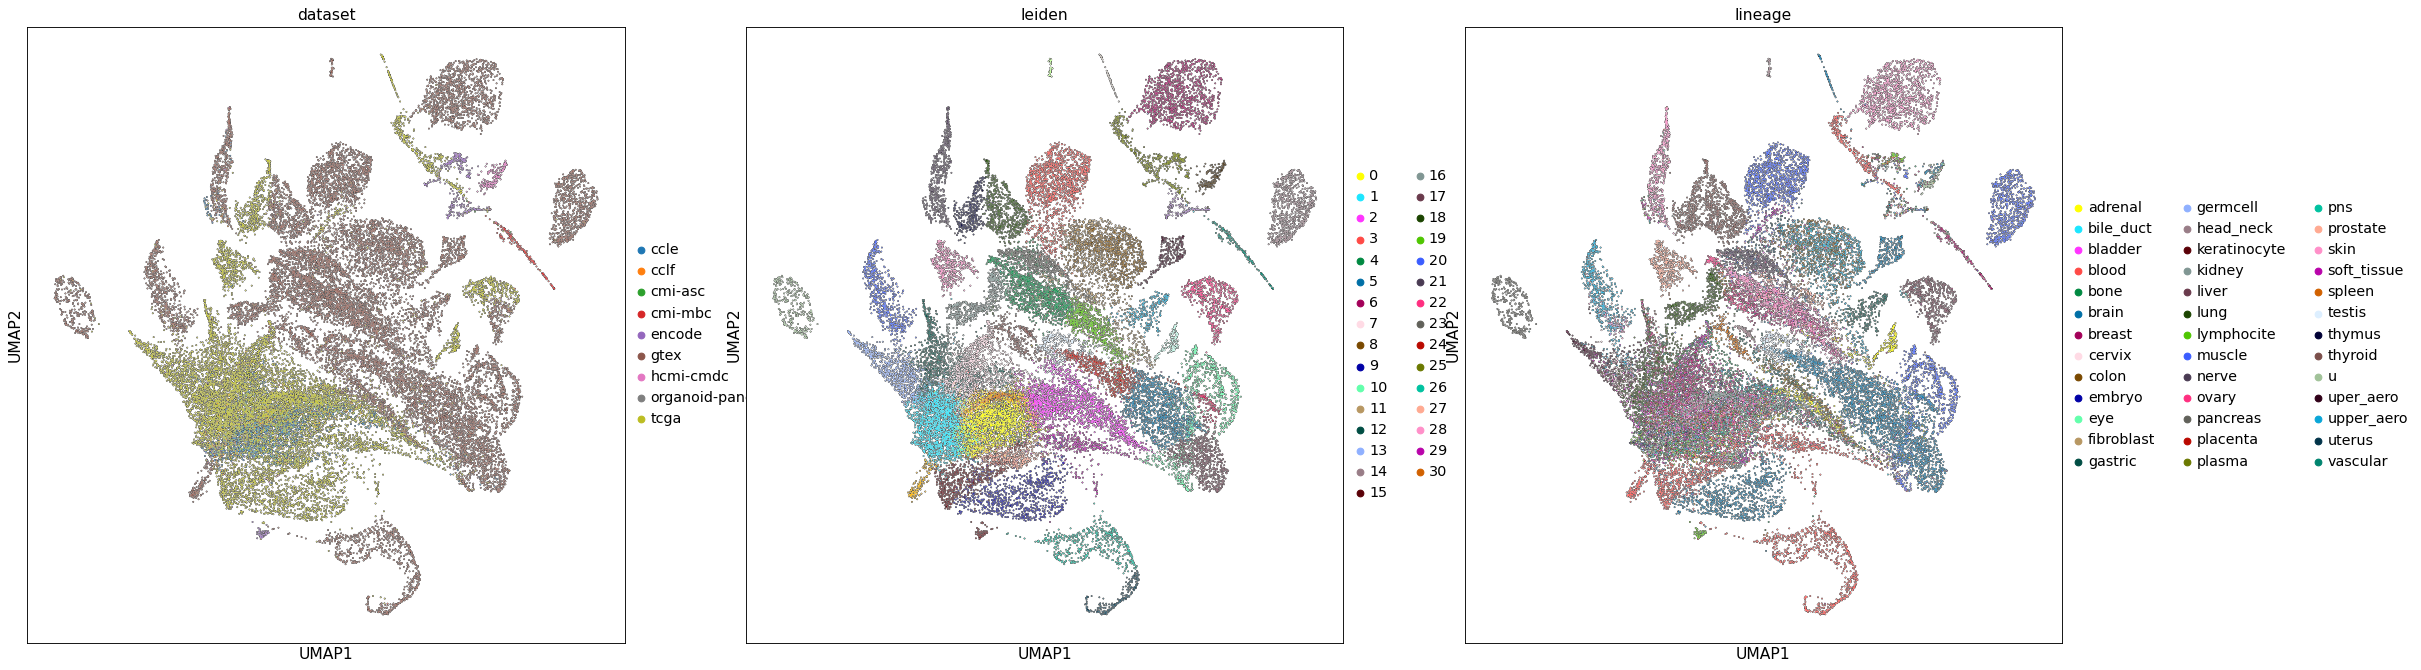

In [678]:
sc.pp.neighbors(data, n_neighbors=12)
sc.tl.leiden(data)
sc.tl.umap(data, n_components=2,
                min_dist=0.5,
                alpha=2,
                spread=1,
                random_state=None)

sc.pl.umap(data, color=['dataset', 'leiden', 'lineage'],
        projection="2d",
        add_outline=True)

In [506]:
from sklearn.decomposition import PCA

In [507]:
red = PCA(n_components=2).fit_transform(total)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
plot.scatter(red, xname="UMAP1", yname="UMAP2", colors=[1]*len(CCLE_expression)+[0]*len(TCGA_expression), radi=.1, labels={k: list(v) for k, v in ann[['tissue_type', 'disease_type', 'cell_type']].reset_index().T.iterrows()})

### saving

In [681]:
data

AnnData object with n_obs × n_vars = 32712 × 53375
    obs: 'disease_type', 'dataset', 'participant_id', 'disease_subtype', 'collection_site', 'doublingt', 'hasebv', 'instability', 'ethnicity', 'morphology', 'sample_name', 'age', 'base_media', 'sex', 'sequencer', 'sample_type', 'tissue_id', 'lineage', 'autolysis_score', 'rin', 'cell_format', 'passage_number', 'assay', 'history', 'contamination', 'leiden'
    uns: 'neighbors', 'leiden', 'umap', 'dataset_colors', 'leiden_colors', 'lineage_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [ ]:
data = an

In [40]:
data.write('temp/celligner_multi_v2.h5ad.gz', compression='gzip')

In [44]:
del total, TCGA_expression, gtex, encode, CCLE_expression, pediatric_PDX_expression

In [41]:
from collections import Counter 
Counter(data.obs.age)

Counter({'adult': 29212,
         'pediatric': 1031,
         'children': 1083,
         'u': 1330,
         'embryo': 56})

In [669]:
data.obs.lineage = data.obs.lineage.replace({"colorectal": "colon", 'gasttric': 'gastric', 'urinary_tract': 'bladder', 'pineal': 'brain', 'endocrine': 'brain'})
data = data[~data.obs.lineage.isin(['gallbladder', 'stem_cell', 'teratoma'])]